In [88]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
import numpy as np
import scipy.stats as stats
import pingouin as pg
import statsmodels.api as sm 
import statsmodels.formula.api as smf 

# Импортируем нужные библиотеки

In [3]:
sales_url = r"C:\Users\fomin\GitHub_projects\Analytics\Zara_sales\zara_sales.csv"
sales = pd.read_csv(sales_url, sep = ';')

sales.head()

# Подгружаем файл с данными и записываем его в датафрейм sales

,Product ID,Product Position,Promotion,Product Category,Seasonal,Sales Volume,brand,url,sku,name,description,price,currency,scraped_at,terms,section
0,185102,Aisle,No,Clothing,No,2823,Zara,https://www.zara.com/us/en/basic-puffer-jacket...,272145190-250-2,BASIC PUFFER JACKET,Puffer jacket made of tear-resistant ripstop f...,19.99,USD,2024-02-19T08:50:05.654618,jackets,MAN
1,188771,Aisle,No,Clothing,No,654,Zara,https://www.zara.com/us/en/tuxedo-jacket-p0889...,324052738-800-46,TUXEDO JACKET,Straight fit blazer. Pointed lapel collar and ...,169.00,USD,2024-02-19T08:50:06.590930,jackets,MAN
2,180176,End-cap,Yes,Clothing,Yes,2220,Zara,https://www.zara.com/us/en/slim-fit-suit-jacke...,335342680-800-44,SLIM FIT SUIT JACKET,Slim fit jacket. Notched lapel collar. Long sl...,129.00,USD,2024-02-19T08:50:07.301419,jackets,MAN
3,112917,Aisle,Yes,Clothing,Yes,1568,Zara,https://www.zara.com/us/en/stretch-suit-jacket...,328303236-420-44,STRETCH SUIT JACKET,Slim fit jacket made of viscose blend fabric. ...,129.00,USD,2024-02-19T08:50:07.882922,jackets,MAN
4,192936,End-cap,No,Clothing,Yes,2942,Zara,https://www.zara.com/us/en/double-faced-jacket...,312368260-800-2,DOUBLE FACED JACKET,Jacket made of faux leather faux shearling wit...,139.00,USD,2024-02-19T08:50:08.453847,jackets,MAN


In [4]:
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

# Устанавливаем настройки для графиков, которые будем использовать

In [5]:
sales.columns = sales.columns.str.lower().str.replace(' ', '_')

# Приводим к удобному для работы виду названия колонок 

In [6]:
sales['revenue_by_item'] = sales.sales_volume * sales.price

# Вводим новый столбец, который описывает выручку с айтема - перемножив количество проданного товара на его цену

In [7]:
sales.duplicated().sum()

# Проверка на дубликаты

0

In [8]:
sales.isnull().sum()

# Проверка на нулевые значения

product_id          0
product_position    0
promotion           0
product_category    0
seasonal            0
sales_volume        0
brand               0
url                 0
sku                 0
name                1
description         2
price               0
currency            0
scraped_at          0
terms               0
section             0
revenue_by_item     0
dtype: int64

In [9]:
is_null_df = sales.isnull()
row_with_null = is_null_df.any(axis=1)
rows_with_null = sales[row_with_null]
rows_with_null

# Поиск строк, где есть хотя бы одно нулевое значение
# Можно дропнуть эти строки из датафрейма, учтя выручку с товаров в них

,product_id,product_position,promotion,product_category,seasonal,sales_volume,brand,url,sku,name,description,price,currency,scraped_at,terms,section,revenue_by_item
60,151925,End-cap,Yes,Clothing,Yes,2179,Zara,https://www.zara.com/us/en/vintage-effect-leat...,320774184-800-97,VINTAGE EFFECT LEATHER BOMBER JACKET,NaN,299.0,USD,2024-02-19T08:50:43.543555,jackets,MAN,651521.0
72,173576,End-cap,Yes,Clothing,No,1838,Zara,https://www.zara.com/us/en/-p04310461.html,336378923-700-2,NaN,NaN,129.0,USD,2024-02-19T08:50:54.476057,jackets,MAN,237102.0


In [10]:
np.round(100 - (sales.revenue_by_item.sum() - rows_with_null.revenue_by_item.sum())/sales.revenue_by_item.sum()*100, 2)

# Считаем % выручки, который уйдет при дропе строчек с нулями

2.28

In [11]:
sales = sales.dropna()

# Дропаем нулевые значения

In [12]:
sales.product_category.unique()

# Категория товаров лишь одна, ее нет смысла анализировать

array(['Clothing'], dtype=object)

In [13]:
# Рассмотрим данные в отношении выручки с товаров

In [14]:
sales.groupby('name').filter(lambda x: len(x) > 1).name.nunique()

# Получается 40 уникальных названий товара, name, повторяются в датафрейме sales

40

In [15]:
nunique_name = sales.groupby(['name'], as_index=False).agg({'revenue_by_item':'count'}).sort_values('revenue_by_item') \
    .rename(columns={'revenue_by_item':'counts_in_df'})

nunique_name.loc[nunique_name.counts_in_df > 1].head()

# Датафрейм уникальных значений name, которые повторяются 2 или более раз

,name,counts_in_df
162,SUIT JACKET,2
185,WOOL BLEND JACKET,2
160,SUEDE SNEAKERS,2
167,TECHNICAL PADDED JACKET,2
0,100% FEATHER FILL PUFFER JACKET,2


In [16]:
repeated_names_df = sales[sales.groupby('name')['name'].transform('size') > 1].sort_values('name')

repeated_names_df.head()

# Датафрейм товаров, где значение name встречается в датафпрейме sales более одного раза

,product_id,product_position,promotion,product_category,seasonal,sales_volume,brand,url,sku,name,description,price,currency,scraped_at,terms,section,revenue_by_item
9,137121,Aisle,No,Clothing,Yes,656,Zara,https://www.zara.com/us/en/100-feather-fill-pu...,312372602-800-2,100% FEATHER FILL PUFFER JACKET,Puffer jacket made of shiny finish technical f...,169.0,USD,2024-02-19T08:50:11.380061,jackets,MAN,110864.0
97,120228,End-cap,No,Clothing,No,2347,Zara,https://www.zara.com/us/en/100-feather-fill-pu...,327116625-505-2,100% FEATHER FILL PUFFER JACKET,Puffer vest made of technical fabric. Fill is ...,89.9,USD,2024-02-19T08:51:09.075286,jackets,MAN,210995.3
200,141547,End-cap,No,Clothing,No,1426,Zara,https://www.zara.com/us/en/baggy-fit-jeans-p06...,315738965-802-34,BAGGY FIT JEANS,Baggy fit jeans. Five pockets. Washed effect. ...,69.9,USD,2024-02-19T08:54:39.496146,jeans,MAN,99677.4
199,198283,End-cap,Yes,Clothing,Yes,1558,Zara,https://www.zara.com/us/en/baggy-fit-jeans-p08...,315836999-406-34,BAGGY FIT JEANS,Baggy fit jeans. Five pockets. Washed effect. ...,69.9,USD,2024-02-19T08:54:39.017964,jeans,MAN,108904.2
92,146839,Aisle,No,Clothing,No,1525,Zara,https://www.zara.com/us/en/bomber-jacket-p0534...,321496813-710-2,BOMBER JACKET,Jacket with padded interior. Rib elastic colla...,109.0,USD,2024-02-19T08:51:06.241653,jackets,MAN,166225.0


In [17]:
a = []
for i in repeated_names_df.name.unique():
    if repeated_names_df.groupby(['name', 'terms']).revenue_by_item.sum().loc[i].size > 1:
        a.append(i)        

# Находим названия товаров name, которые в датафрейме sales встречаются с разной маркировкой в типе товара (параметр terms)
# и записываем их в лист. 

sales.query('name == @a').head()

# Сортируем датафрейм sales по тем наименованиям товаров, name, которые встречаются с разной маркировкой по параметру terms -
# тип товара

# Вопрос состоит в том, ошибка ли это или есть какие-то особенности, в реальной жизни имел бы смысл отправить запрос на
# разъяснение ситуации в соответствующую команду, т.к. товар, который имеет в названии "Jacket" тут может быть отнесен
# и к jackets, и к sweaters

,product_id,product_position,promotion,product_category,seasonal,sales_volume,brand,url,sku,name,description,price,currency,scraped_at,terms,section,revenue_by_item
7,182157,Aisle,No,Clothing,No,2421,Zara,https://www.zara.com/us/en/suit-jacket-in-100-...,322972485-431-46,SUIT JACKET IN 100% LINEN,Straight fit blazer made of linen. Notched lap...,159.0,USD,2024-02-19T08:50:10.200777,jackets,MAN,384939.0
10,113143,Aisle,Yes,Clothing,Yes,2663,Zara,https://www.zara.com/us/en/herringbone-texture...,316207900-710-2,HERRINGBONE TEXTURED JACKET,Jacket made of wool blend fabric. Lapel collar...,129.0,USD,2024-02-19T08:50:12.011296,jackets,MAN,343527.0
11,140028,Aisle,Yes,Clothing,Yes,1260,Zara,https://www.zara.com/us/en/oversized-cropped-j...,329186122-800-2,OVERSIZED CROPPED JACKET LIMITED EDITION,Oversized cropped jacket. Notched lapel collar...,159.0,USD,2024-02-19T08:50:12.510507,jackets,MAN,200340.0
12,134693,Aisle,Yes,Clothing,No,2124,Zara,https://www.zara.com/us/en/leather-biker-jacke...,311297791-800-2,LEATHER BIKER JACKET,Jacket with lapel collar and snap button detai...,169.0,USD,2024-02-19T08:50:13.210501,jackets,MAN,358956.0
13,151396,Front of Store,Yes,Clothing,Yes,729,Zara,https://www.zara.com/us/en/cropped-leather-jac...,323134418-800-3,CROPPED LEATHER JACKET,Leather jacket. Cropped length. Lapel collar a...,439.0,USD,2024-02-19T08:50:13.771115,jackets,MAN,320031.0


In [18]:
# Построим топ-10 товаров по выручке, т.е. 10 уникальных наименований, продажа которых принесла наибольшую выручку

In [19]:
top10_rev = sales \
    .groupby('name', as_index=False) \
    .agg({'revenue_by_item':'sum'}) \
    .sort_values('revenue_by_item', ascending = False).head(10)

top10_rev
# Считаем выручку по названию товара, name, в списке продаж, находим топ-10 продаж

,name,revenue_by_item
39,CONTRASTING PATCHES BOMBER JACKET,889308.0
163,SUIT JACKET IN 100% LINEN,816675.0
57,FAUX LEATHER BOMBER JACKET,798852.6
118,PLAID OVERSHIRT,695369.0
136,RIB COLLAR JACKET,685883.0
141,SLIM FIT SUIT JACKET,675719.0
124,POCKET OVERSHIRT,666987.8
155,SUEDE JACKET,649140.0
24,BOUCLÉ TEXTURED JACKET,609950.0
123,POCKET JACKET,608503.0


Text(0.5, 1.0, 'Top-10 products number of purchases by price distribution')

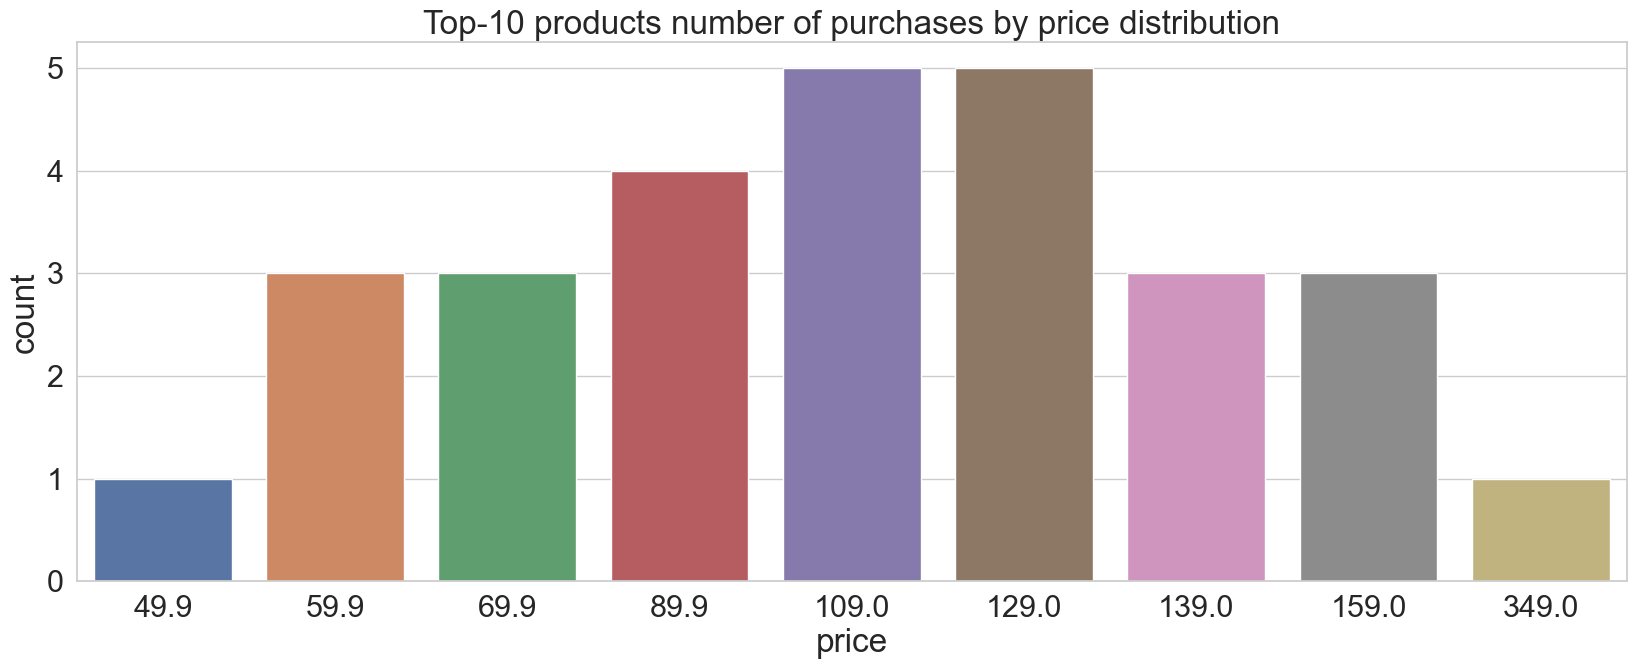

In [20]:
top10_items_rev_df = sales.query('name == @top10_rev.name.to_list()')

# Создаем датафрейм, в который входят только строки с наименованиями тех товаров, что в сумме приносят топ-10 выручки

ax0 = sns.countplot(top10_items_rev_df, x = 'price')
ax0.set_title('''Top-10 products number of purchases by price distribution''')

# Строим распределение цен по которым продаются товары (по name), приносящие в сумме топ-10 выручки среди всех товаров

Text(0.5, 1.0, "Top-10 products revenue by product's price")

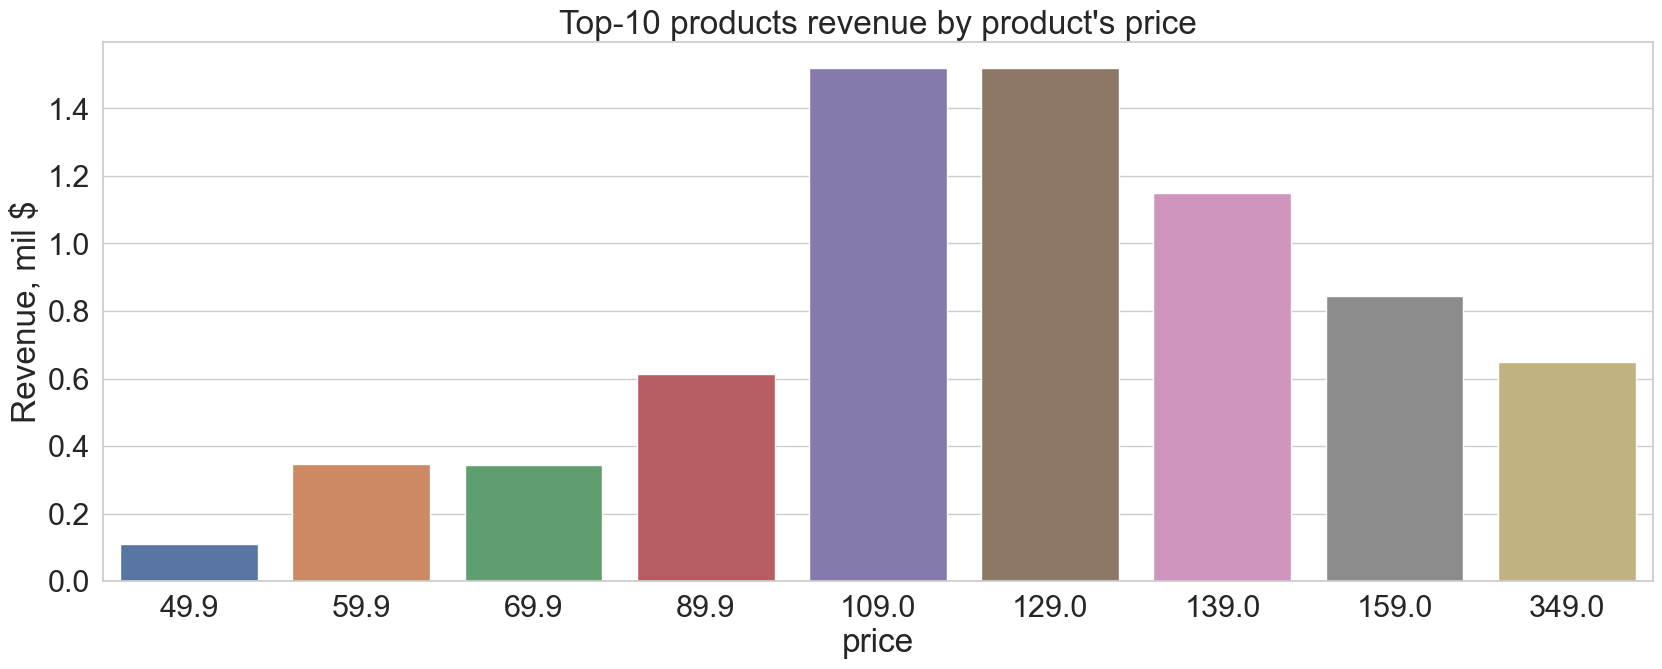

In [21]:
ax0_2 = sns.barplot(y=top10_items_rev_df \
                .groupby('price', as_index=False) \
                .revenue_by_item.sum() \
                .revenue_by_item \
                .rename('Revenue, mil $') / 1000000,
            x=top10_items_rev_df \
                .groupby('price', as_index=False) \
                .revenue_by_item.sum() \
                .price)
ax0_2.set_title('''Top-10 products revenue by product's price''')
# Распределение выручки в зависимости от цен товаров из топ-10 по принесенной выручке
# Больше всего денег приносят в топе товары со стоимость 109$ и 129$

Text(0.5, 1.0, "Top-10 products revenue by product's type and position")

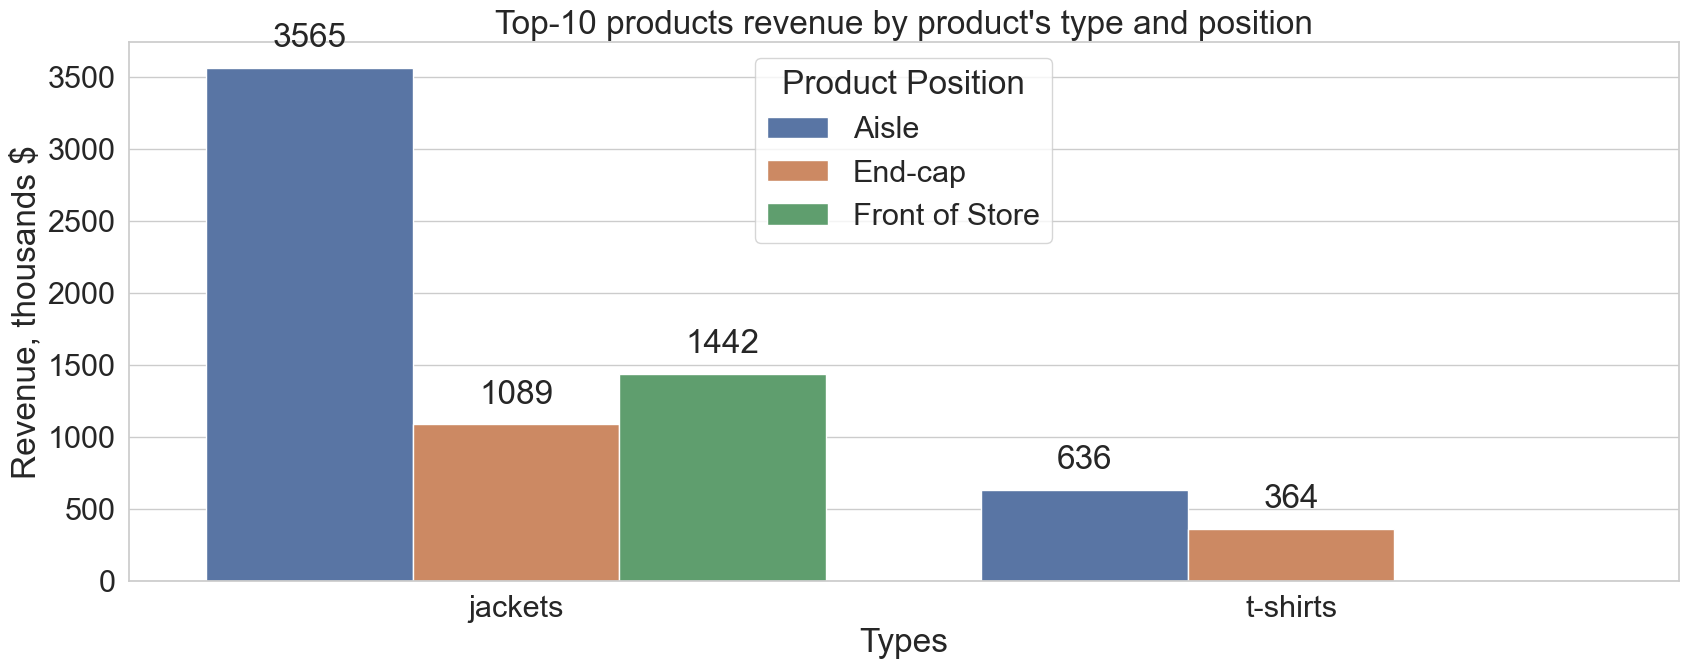

In [22]:
top10_items_terms_prodpos_rev = top10_items_rev_df.groupby(['terms', 'product_position'], as_index=False).revenue_by_item.sum()

# Строим датафрейм о выручке топ-10 продуктах в зависимости от параметров terms и product_position

ax0_3 = sns.barplot(x=top10_items_terms_prodpos_rev.terms.rename('Types'),
            y=top10_items_terms_prodpos_rev.revenue_by_item.rename('Revenue, thousands $') / 1000, 
            hue=top10_items_terms_prodpos_rev.product_position.rename('Product Position'))

for c in ax0_3.containers:
    ax0_3.bar_label(c, fmt='%.0f', padding=10)
    
ax0_3.set_title('''Top-10 products revenue by product's type and position''')

# Визуализировали выручку топ-10 продуктов в зависимости от их типа (type) и позиции в магазине (product_position)

In [23]:
# Изучим теперь распределение выручки по всем ценам исходного датафрейма sales

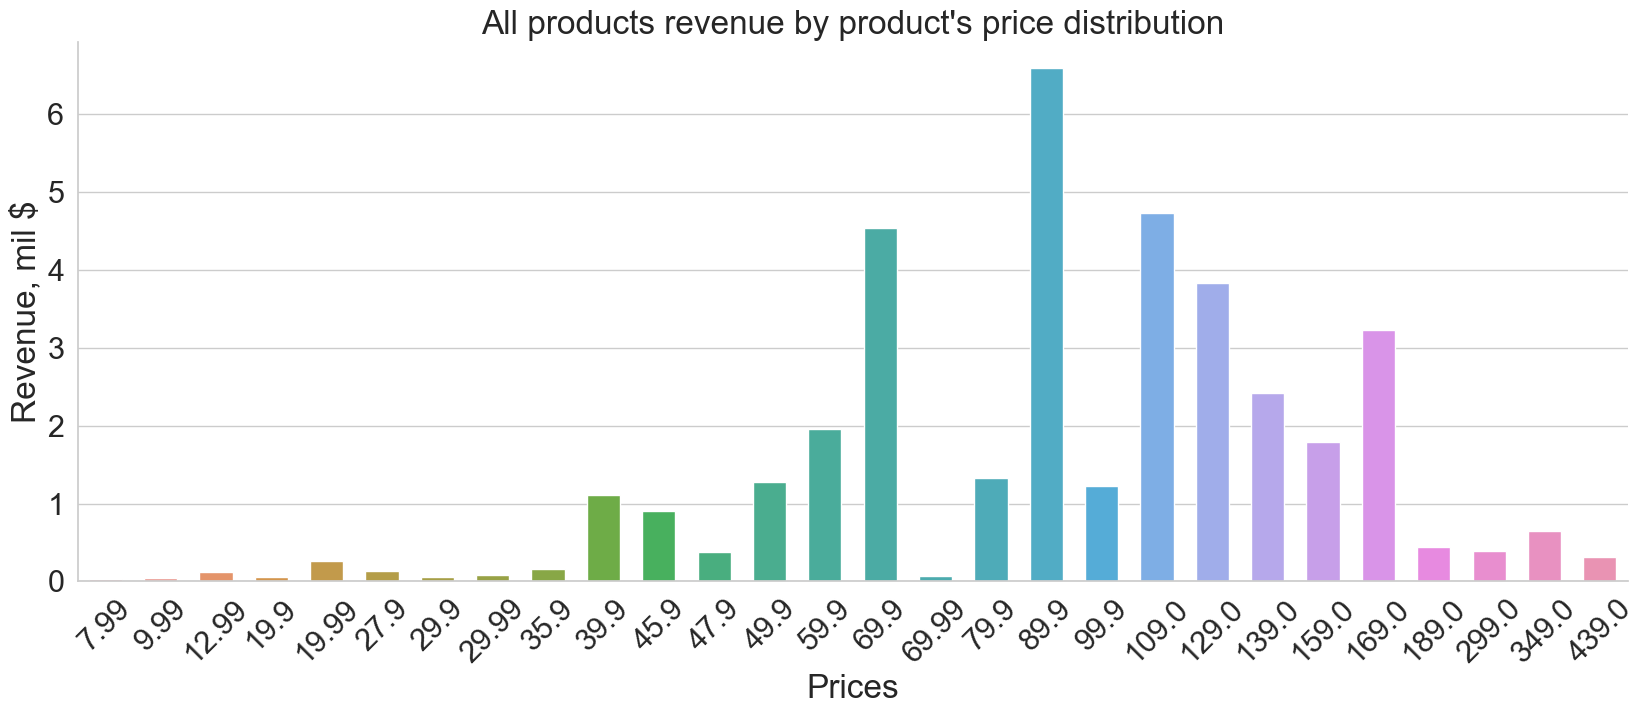

In [24]:
rev_by_price_df = sales \
    .groupby('price', as_index = False) \
    .revenue_by_item.sum()

# Создаем датафрейм выручки, полученной в зависимости от цены айтема


plt.pyplot.xticks(rotation=45)
ax0_4 = sns.barplot(x = rev_by_price_df.price, y = rev_by_price_df.revenue_by_item/1000000, width = 0.6)
ax0_4.set_title('''All products revenue by product's price distribution''')
ax0_4.set(ylabel='Revenue, mil $', xlabel='Prices')
sns.despine()

# Получаем распределение выручки в зависимости от цены вещи - смотрим, какие ценовые сегменты приносят более всего денег


# кластеризуй эти данные по ценам

In [25]:
# Теперь рассмотрим данные в разрезе мужского и женского отдела продаж

Text(0.5, 1.0, 'Number of purchases by gender section of the store')

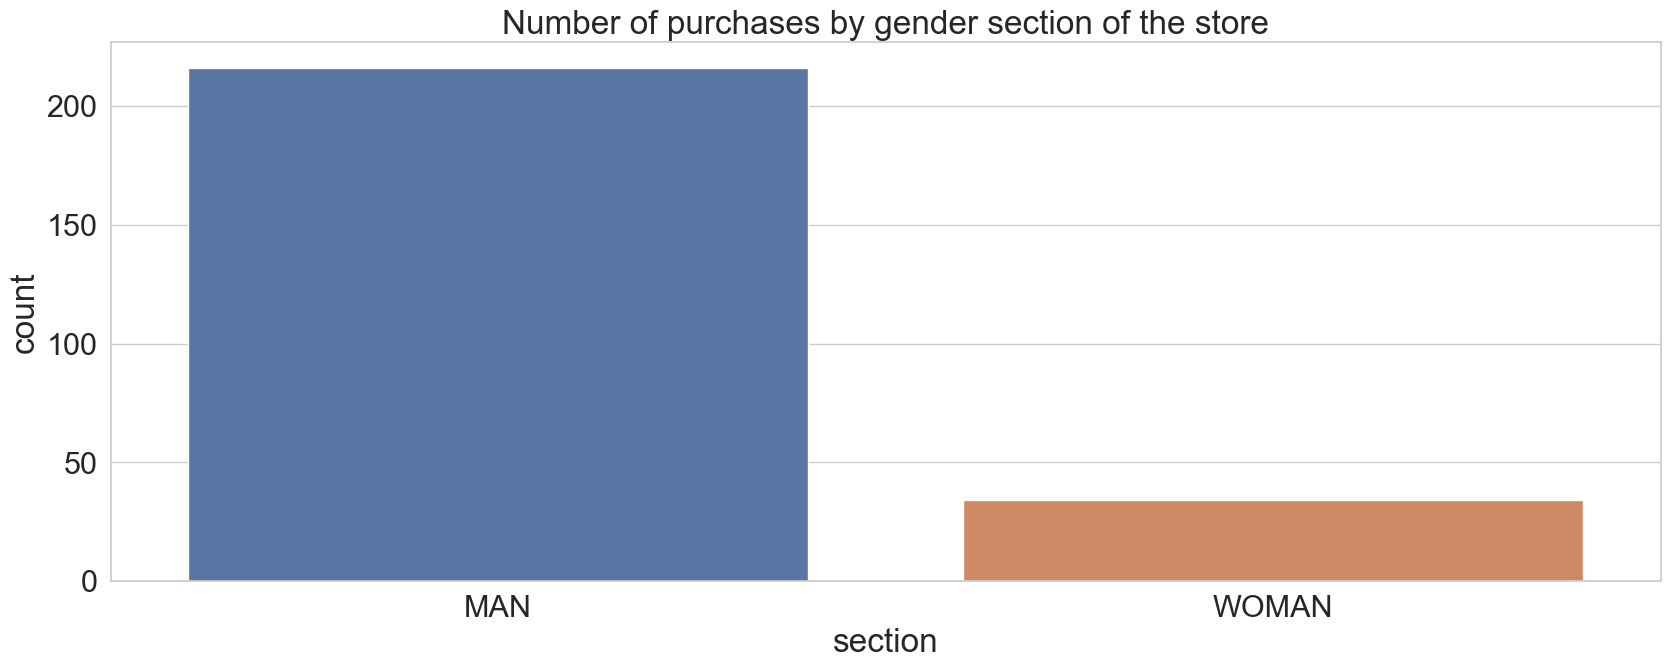

In [26]:
ax0_5 = sns.countplot(sales, x = "section")
ax0_5.set_title('''Number of purchases by gender section of the store''')

# Количество покупок в мужском и женском отделах

Text(0.5, 1.0, 'Revenue by gender section of the store')

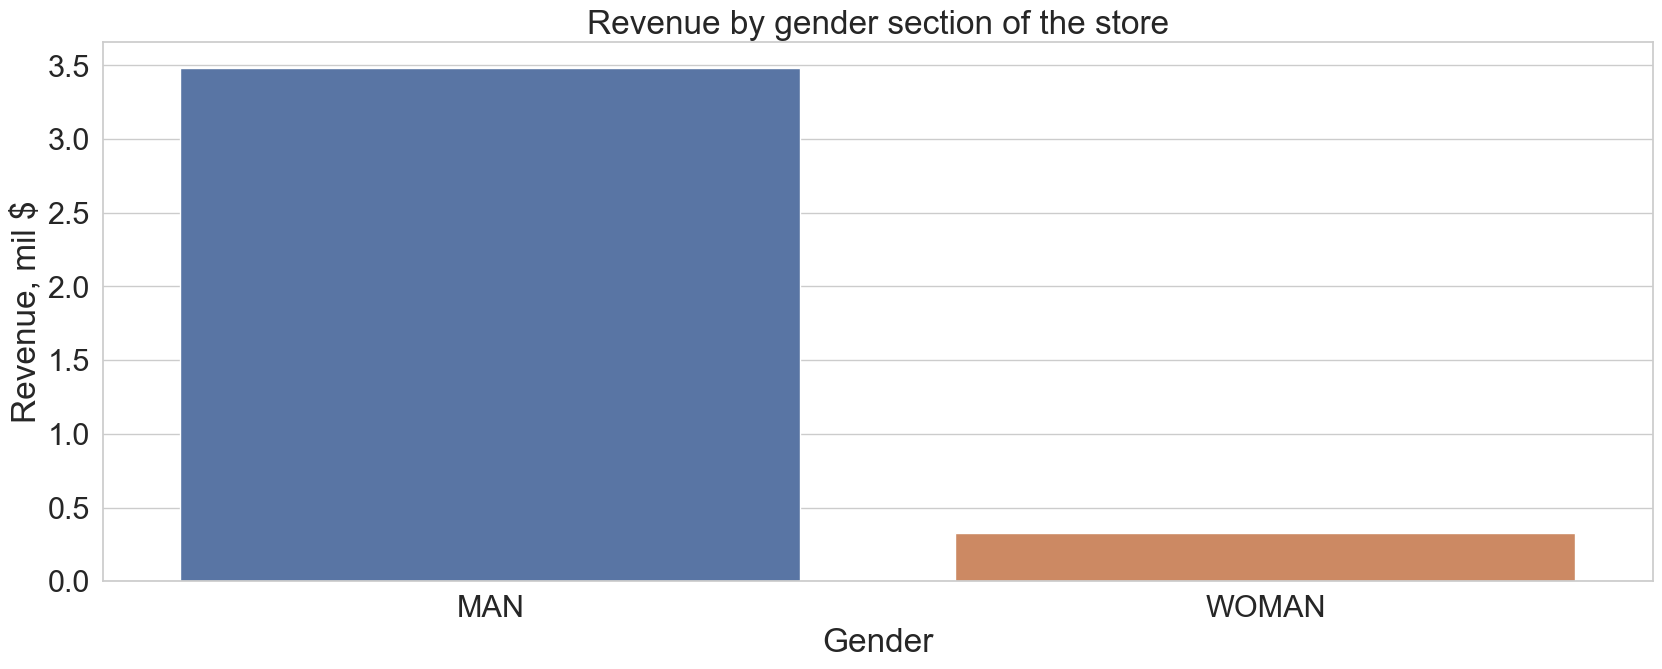

In [27]:
rev_by_gender_df = sales \
    .groupby('section', as_index=False) \
    .revenue_by_item.sum() \
    .rename(columns={'revenue_by_item':'revenue'})

rev_by_gender_df['revenue_share'] = np.round(rev_by_gender_df.revenue / rev_by_gender_df.revenue.sum() * 100,1)

# Создаем датафрейм с выручкой по гендерам rev_by_gender_df
# и отдельно столбец с долей выручки каждого отдела продаж (М и Ж) revenue_share

ax1 = sns.barplot(x=rev_by_gender_df.section, y=rev_by_gender_df.revenue /10000000)
ax1.set(xlabel='Gender', ylabel='Revenue, mil $')
ax1.set_title('''Revenue by gender section of the store''')

# Выручка, принесенная мужским и женским отделами

In [28]:
count_purch_by_gender_df = sales \
    .groupby('section', as_index=False) \
    .sales_volume.sum() \
    .rename(columns={'sales_volume':'number_of_purchases'})

count_purch_by_gender_df['num_of_purch_share'] = np.round(count_purch_by_gender_df.number_of_purchases /
                                                          count_purch_by_gender_df.number_of_purchases.sum() * 100,1)
# Создаем датафрейм с количеством покупок по гендерной секции count_purch_by_gender_df
# и отдельно столбец с долей количества покупок каждого отдела продаж (М и Ж) num_of_purch_share

gender_df = rev_by_gender_df.merge(count_purch_by_gender_df)
gender_df['mean_revenue_by_gend'] = np.round(gender_df.revenue /
                                             gender_df.number_of_purchases, 2)
gender_df['mean_rev_by_gen_share'] = np.round(gender_df.mean_revenue_by_gend /
                                              gender_df.mean_revenue_by_gend.sum() * 100, 2)

gender_df

# Создаем столбец mean_revenue_by_gend, в котором посчитали среднюю выручку с одной покупки для секций мужчин и женщин
# Также создали столбец mean_rev_by_gen_share, в котором посчитали долю секций в средней выручке

,section,revenue,revenue_share,number_of_purchases,num_of_purch_share,mean_revenue_by_gend,mean_rev_by_gen_share
0,MAN,34824040.03,91.4,392182,86.1,88.80,63.21
1,WOMAN,3275813.45,8.6,63374,13.9,51.69,36.79


In [29]:
# Все относительные показатели, такие, как доля выручки на гендерный отдел, revenue_share,
# доля количества покупок на гендерный отдел, num_of_purch_share,
# и доля в среднем чеке по гендерному отделу, mean_rev_by_gen_share,
# говорят о том, что основной целевой аудиторией магазина являются мужчины, 
# потому что их средняя покупка приносит намного больше денег, в среднем они намного чаще покупают, и их просто больше 

# На основе описанных тезисов можно сделать вывод, что в моменте мужская целевая аудитория сильно важнее для магазина, 
# чем женская

In [30]:
# Рассмотрим теперь данные по категории товаров - колонке terms

Text(0.5, 1.0, 'Revenue by product type')

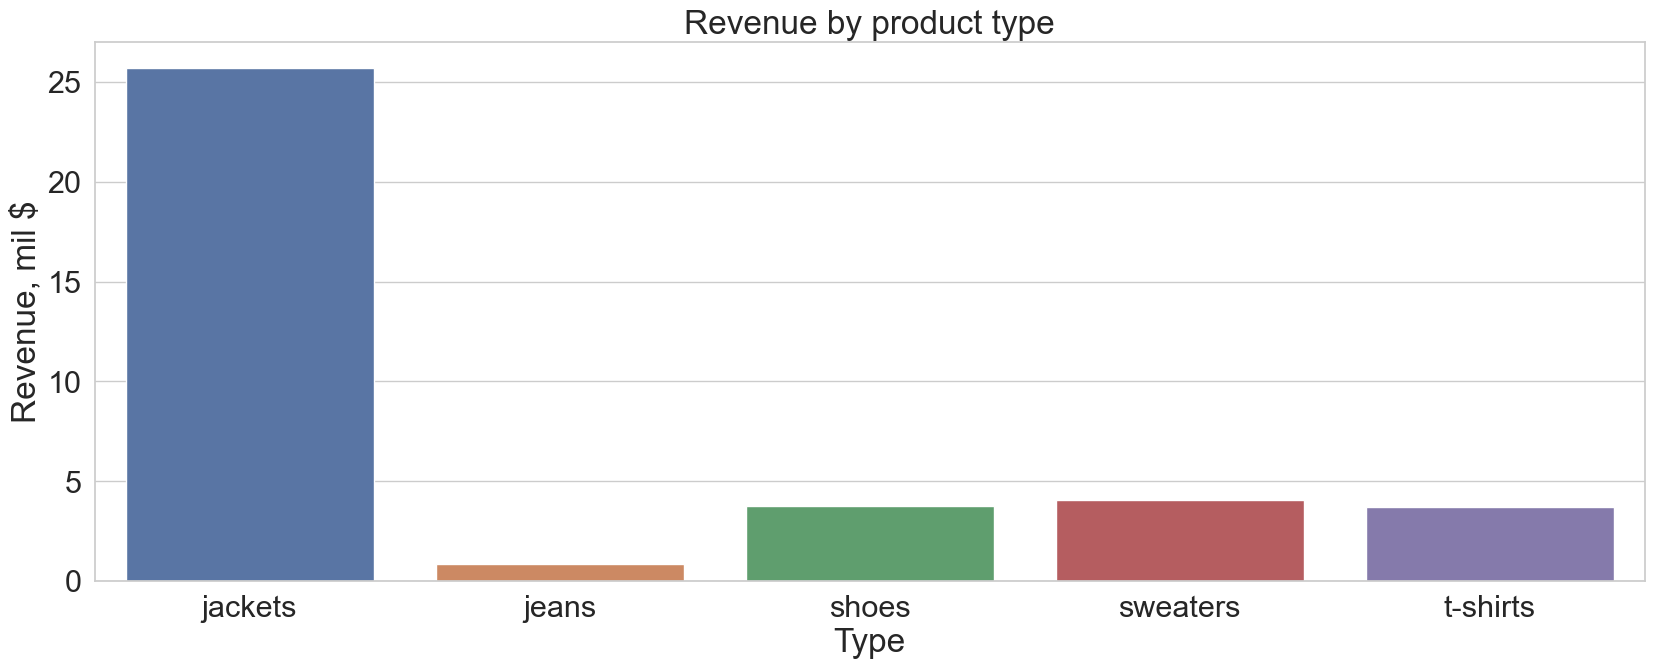

In [31]:
ax2_0 = sns.barplot(x = sales \
                      .groupby('terms', as_index=False) \
                      .revenue_by_item.sum() \
                      .terms,
                  y = sales \
                      .groupby('terms', as_index=False) \
                      .revenue_by_item.sum() \
                      .revenue_by_item / 1000000)

ax2_0.set(ylabel = 'Revenue, mil $', xlabel = 'Type')
ax2_0.set_title('''Revenue by product type''')

# Распределение выручки по типу товаров. Очевидный лидер - jackets. Попробуем разобраться почему это так

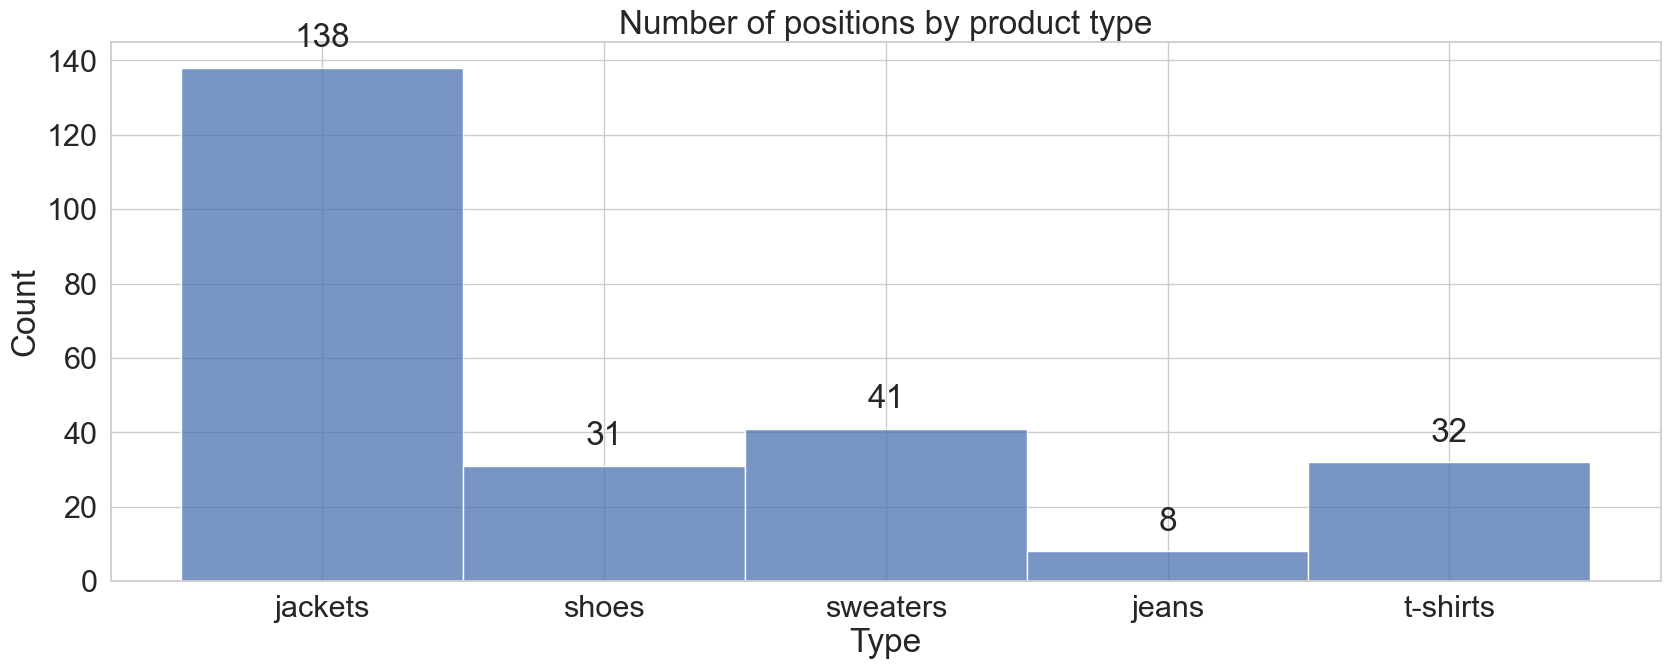

In [32]:
ax1_2 = sns.histplot(sales.terms.rename('Type'))
ax1_2.set_title('''Number of positions by product type''')

for container in ax1_2.containers:
    ax1_2.bar_label(container, padding=10)

# Построим распределение количества позиций в ассортименте по их типу

[Text(0.5, 0, 'Types'),
 Text(0, 0.5, 'Number of purchases'),
 Text(0.5, 1.0, 'Number of product purchases by product type')]

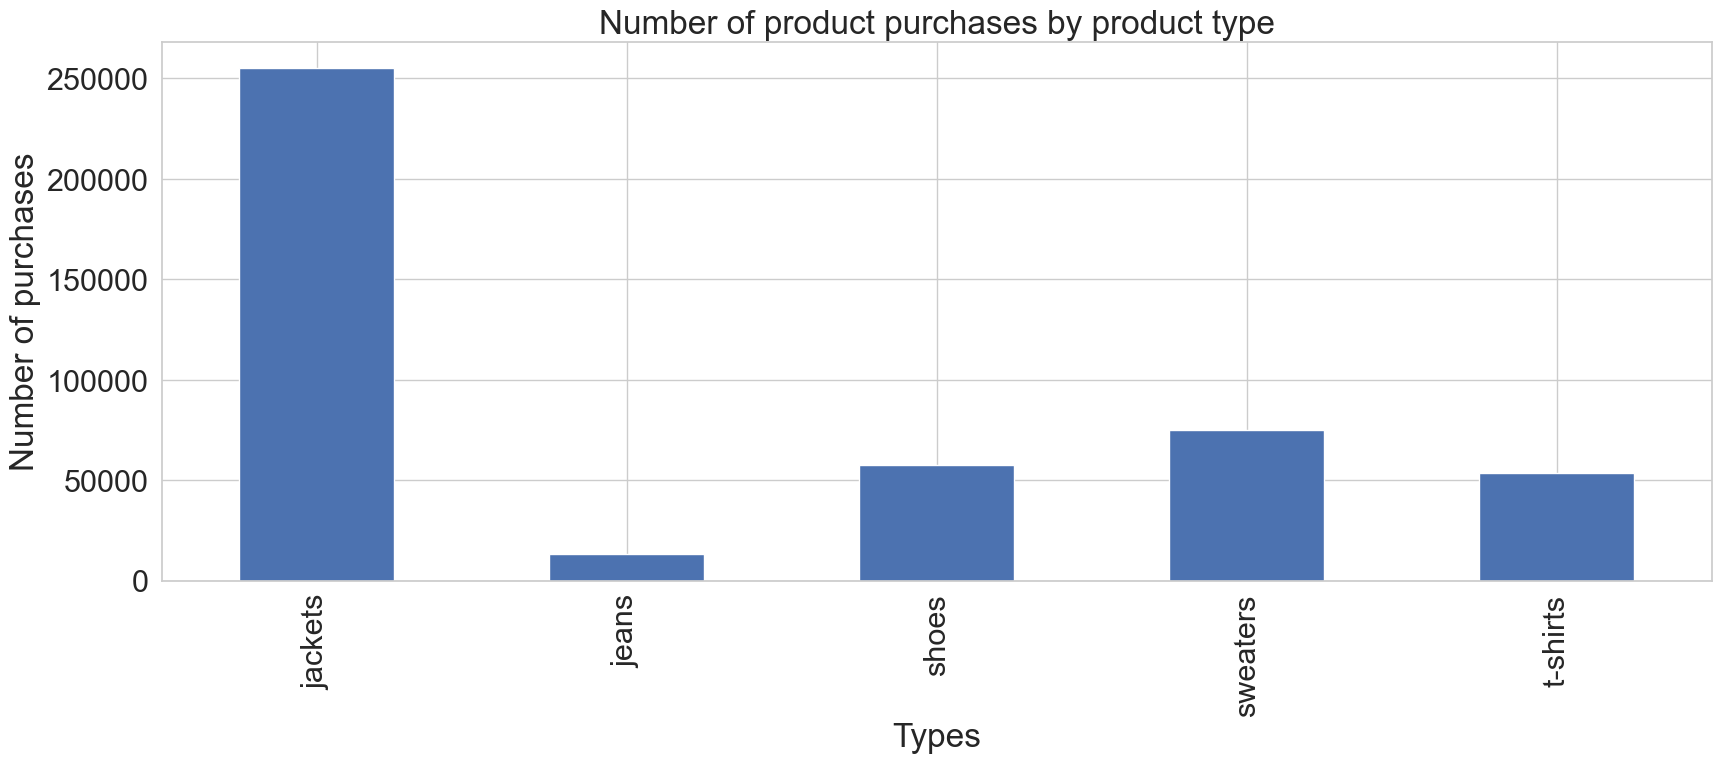

In [33]:
ax1_3 = sales \
    .groupby('terms') \
    .sales_volume.sum() \
    .plot.bar()

ax1_3.set(xlabel = 'Types',
          ylabel = 'Number of purchases',
          title = 'Number of product purchases by product type')

# График зависимости количества проданных товаров (sales_volume) от их типа (terms)

[Text(0.5, 0, 'Types'),
 Text(0, 0.5, 'Revenue, $'),
 Text(0.5, 1.0, 'Product mean revenue dependency on product type')]

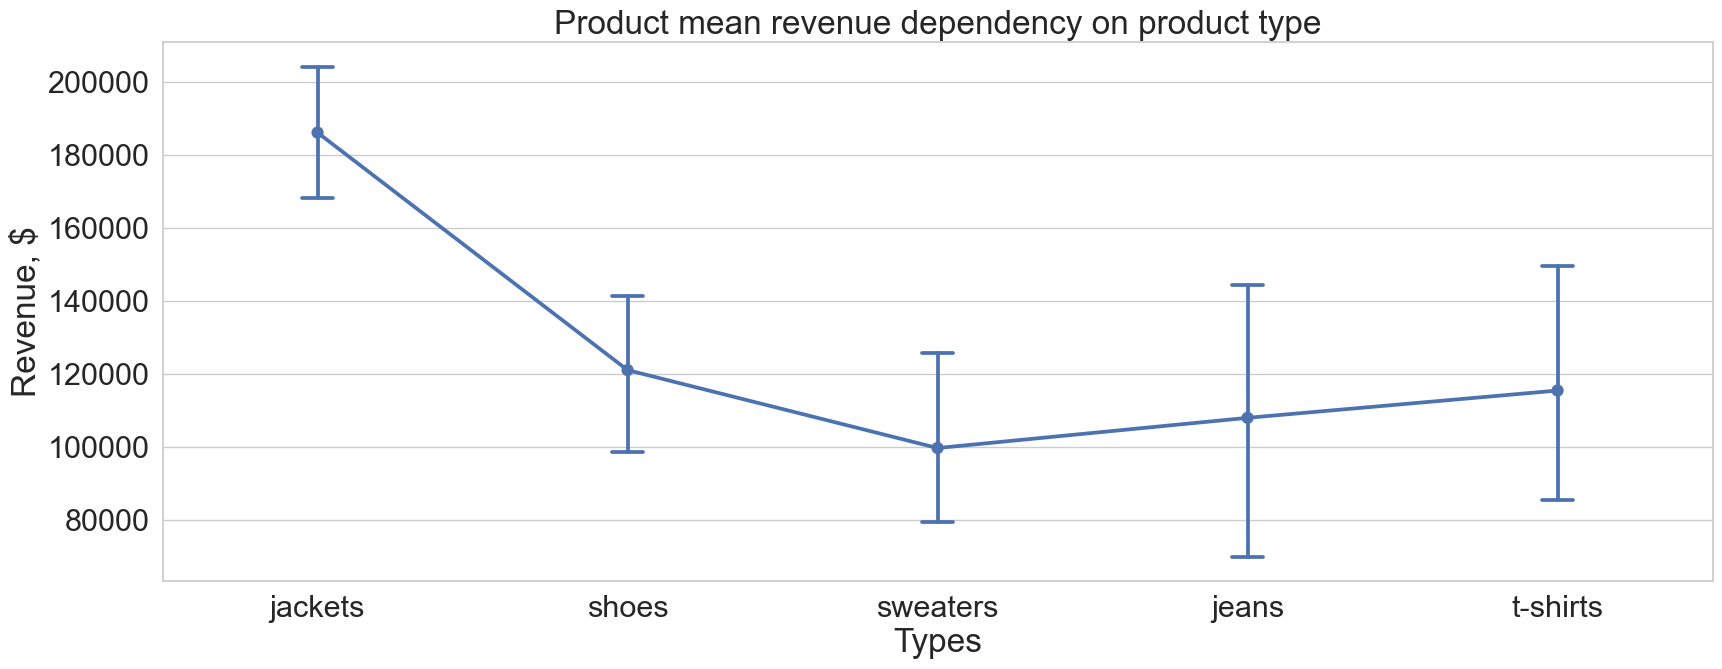

In [34]:
ax2_2 = sns.pointplot(x='terms', y='revenue_by_item', data=sales, capsize=0.1, errorbar='ci')
ax2_2.set(xlabel = 'Types', ylabel='Revenue, $', title='Product mean revenue dependency on product type')

# Находим среднюю выручку с каждого типа товара и строим 95% доверительный интервал
# Средняя выручка с jackets значительно выше, чем у других типов товара

Text(0.5, 1.0, "Sales volume by product's type boxplot distribution")

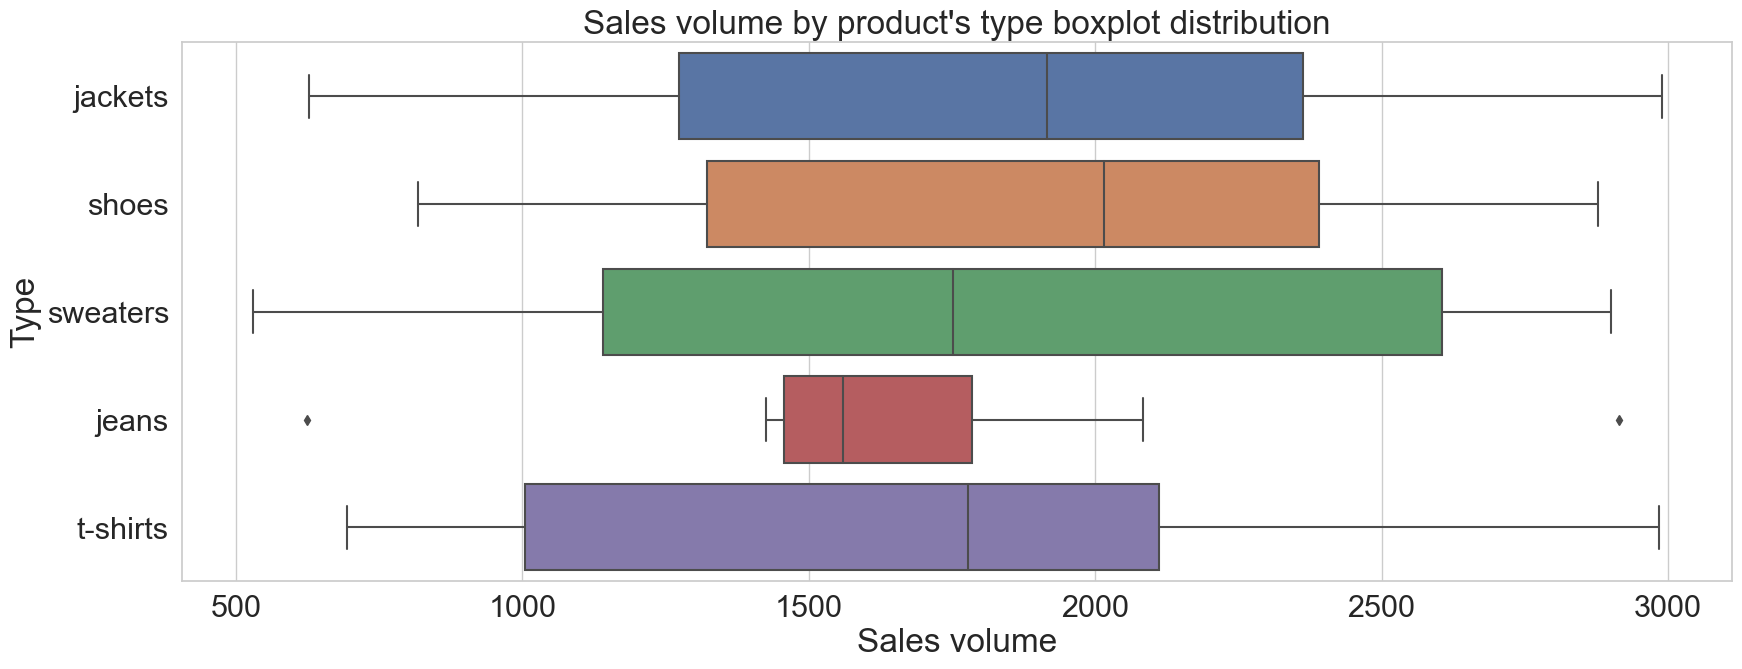

In [35]:
ax2_3 = sns.boxplot(data = sales, x='sales_volume', y = 'terms')

ax2_3.set(xlabel = 'Sales volume', ylabel = 'Type')
ax2_3.set_title('''Sales volume by product's type boxplot distribution''')

# Здесь приведен боксплот количества проданного товара в зависимости от его типа
# Видно, что люди покупают примерно одинаково все типы, кроме jeans - вероятно людям одинаково нравятся все представленные
# товары внутри этой группы

[Text(0.5, 0, 'Types'),
 Text(0, 0.5, 'Price, $'),
 Text(0.5, 1.0, 'Product mean price dependency on product type')]

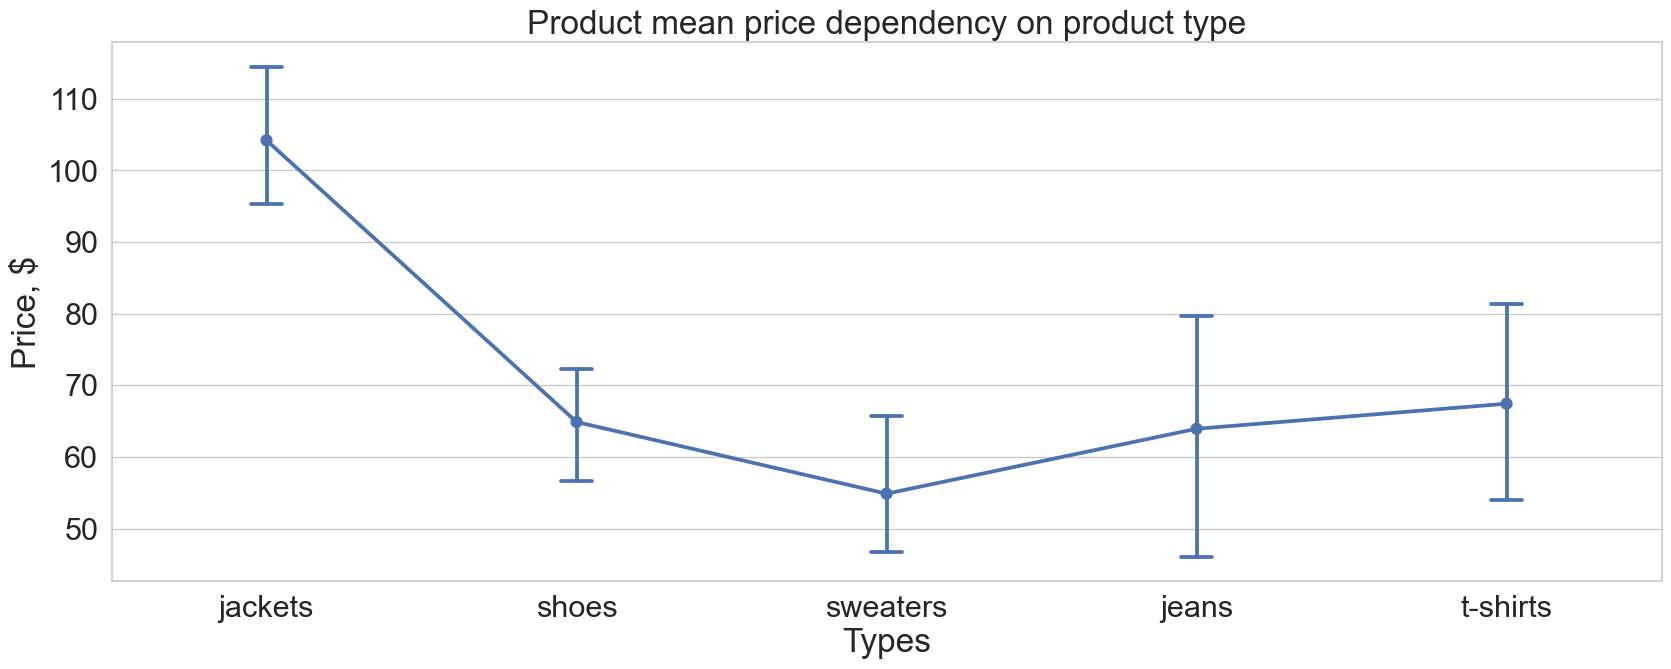

In [36]:
ax2_32 = sns.pointplot(x='terms', y='price', data=sales, capsize=0.1, errorbar='ci')
ax2_32.set(xlabel = 'Types', ylabel='Price, $', title='Product mean price dependency on product type')

# Находим средний прайс с каждого типа товара и строим 95% доверительный интервал
# Средний прайс jackets значительно выше, чем у других типов товара

Text(0.5, 1.0, "Product's prices by product's prices boxplot distribution")

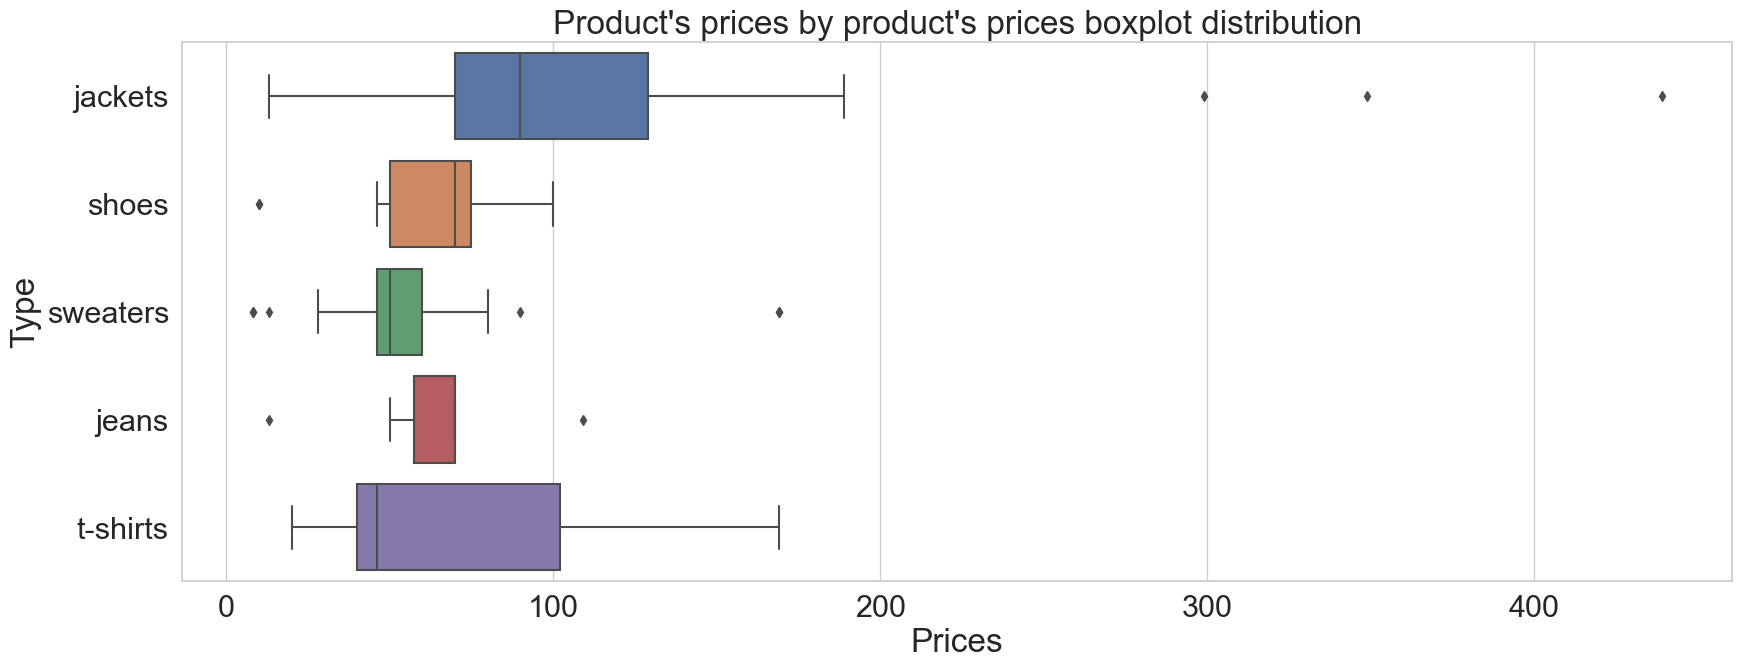

In [37]:
ax2_4 = sns.boxplot(data = sales, x = 'price', y = 'terms')

ax2_4.set(xlabel = 'Prices', ylabel = 'Type')
ax2_4.set_title('''Product's prices by product's prices boxplot distribution''')

# В среднем наибольшие цены встречаются чаще всего в категории jackets

In [38]:
# По полученным данным получается, что выручка с jackets намного выше выручки с других типов продуктов за счет прайса,
# по которому jackets продаются - он значительно больше цен на другие типы товаров

In [39]:
# Теперь посмотрим на данные в отношении товаров, которые участвуют в промоушене (столбец promotion)

In [40]:
revenue_with_prom = sales \
    .query('promotion == "Yes"') \
    .revenue_by_item.sum() 
revenue_without_prom = sales \
    .query('promotion == "No"') \
    .revenue_by_item.sum()

np.round((revenue_with_prom - revenue_without_prom) / revenue_with_prom * 100, 2)

# Выручка с товаров, участвующих в промоушне, превышает выручку с товаров вне промоушна на 0.58%. 
# Имеет смысл сравнить полученную прибыль с этой дельты выручки с затратами на промоушн,
# чтобы определить эффективность настоящей программы промоушна
# Однако в рамках датасета, который используется в этом проекте, таких данных нет

0.58

In [41]:
# Следует также оценить вклад сезонности товаров на продажи (столбец seasonal)

In [42]:
revenue_with_season = sales.groupby('seasonal', as_index=False).revenue_by_item.sum()

rev_season_diff = np.round(revenue_with_season \
          .query('seasonal == "Yes"') \
          .revenue_by_item.sum() - revenue_with_season.query('seasonal == "No"').revenue_by_item.sum(),2)
rev_season_diff

# Выручка с сезонных товаров превышает выручку с несезонных на 261281.84

261281.84

In [43]:
np.round(rev_season_diff /  revenue_with_season \
          .query('seasonal == "Yes"') \
          .revenue_by_item.sum() * 100,2)

# Выручка с сезонных товаров превышает выручку с несезонных на 1.36%.

1.36

In [44]:
# Обратим внимание на данные по товарам относительно их местонахождения в помещении магазина (столбец product_position)
# Есть 3 варианта: Aisle (проход, коридор), end-cap (конец прохода - aisle), front of store (лицевая часть магазина)

[Text(1, 0, '15'), Text(1, 0, '12'), Text(1, 0, '11')]

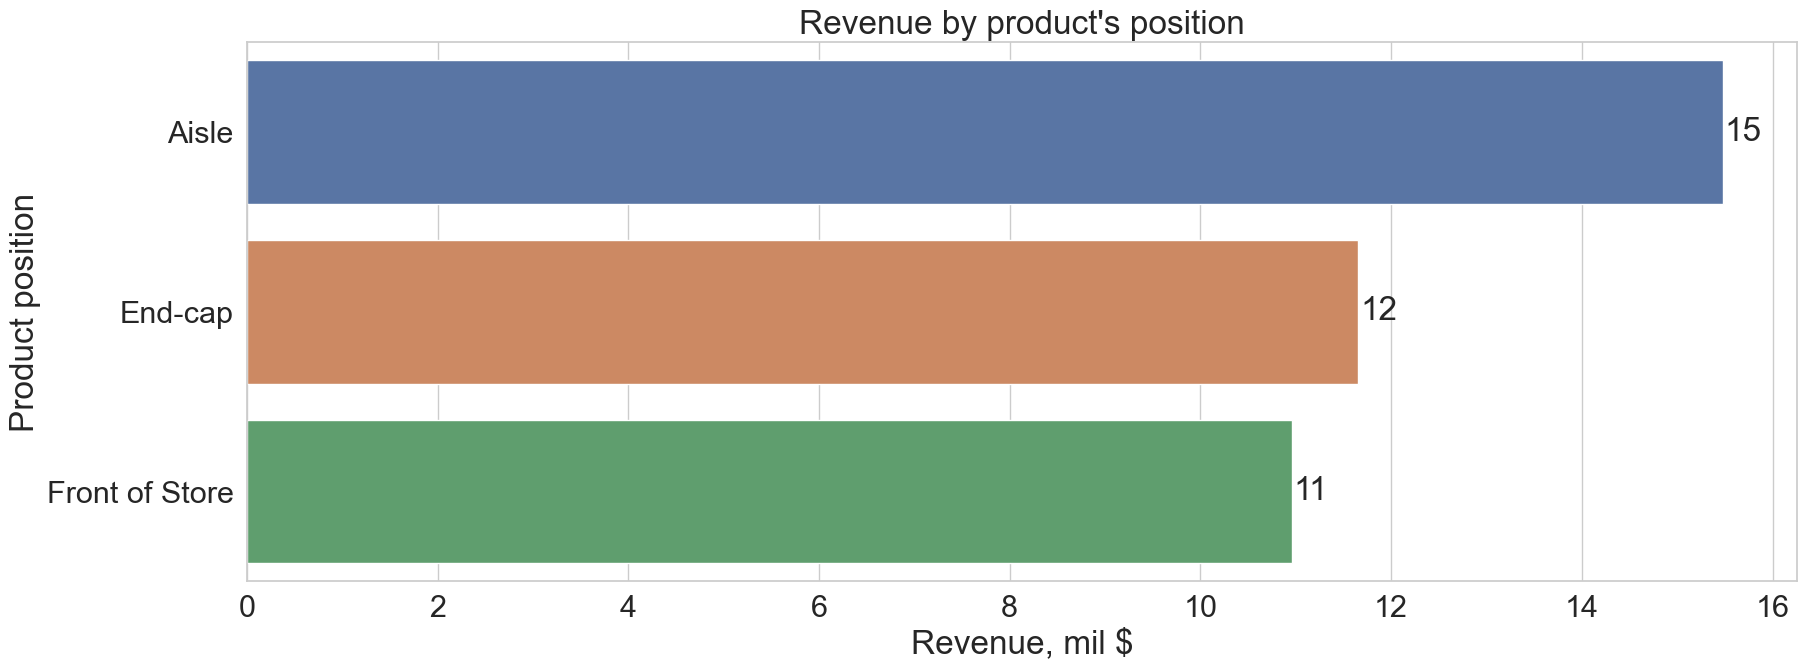

In [45]:
rev_by_prod_pos_df = sales.groupby('product_position', as_index=False).revenue_by_item.sum()

ax3_1 = sns.barplot(y = rev_by_prod_pos_df.product_position,
                    x = rev_by_prod_pos_df.revenue_by_item / 1000000)
ax3_1.set(xlabel='Revenue, mil $', ylabel='Product position')
ax3_1.set_title('''Revenue by product's position''')
ax3_1.bar_label(ax3_1.containers[0], fmt='%.0f', padding=1)

# Распределение выручки по разным сегментам магазина

Text(0.5, 1.0, "Revenue by product's position and type")

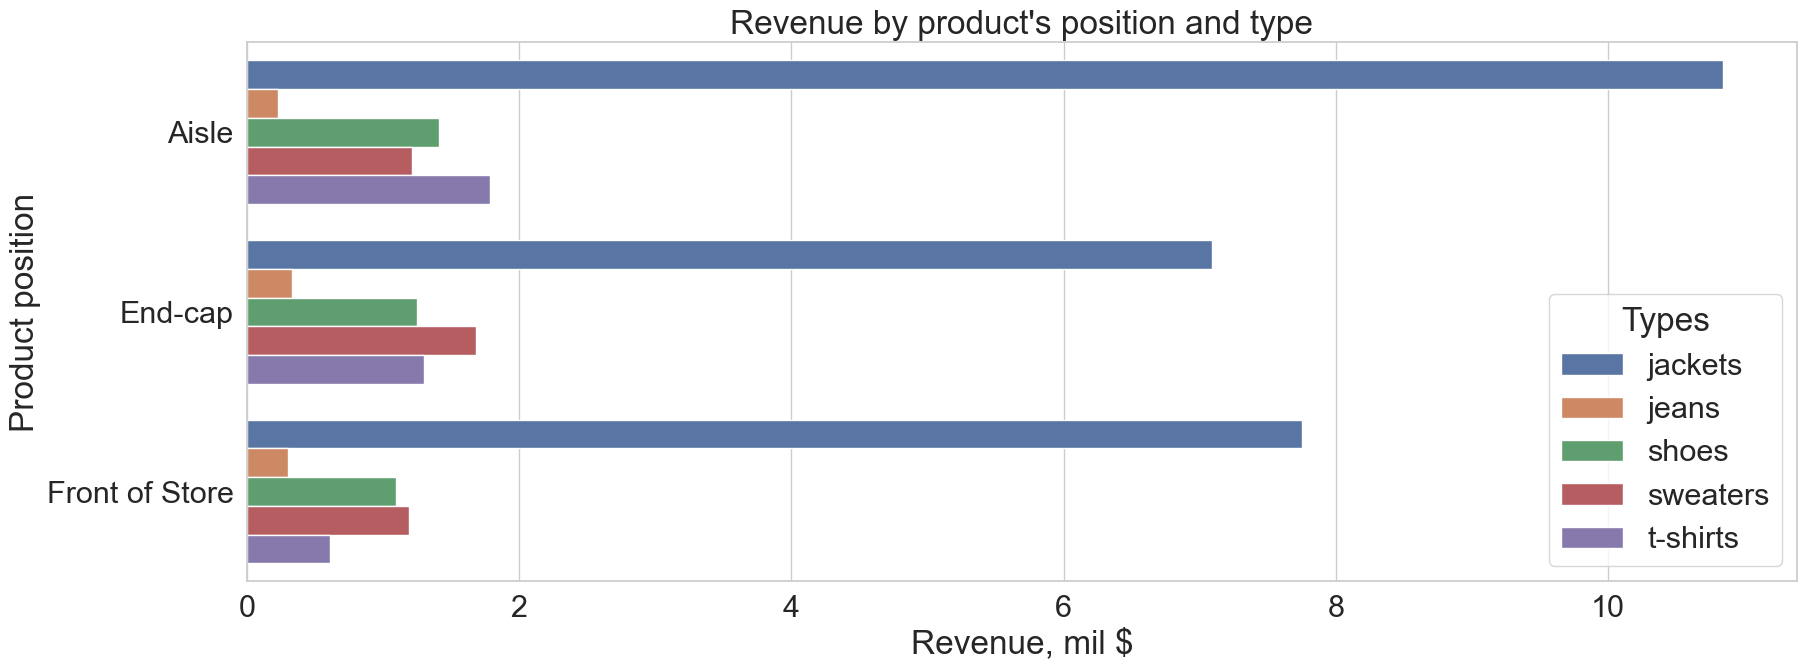

In [46]:
rev_by_prod_pos_w_terms_df =  sales.groupby(['product_position', 'terms'], as_index=False).revenue_by_item.sum()

# Строим датасет из sales с группировкой по типу товар, его местоположению в магазине и принесенной выручке

ax3_2 = sns.barplot(y   = rev_by_prod_pos_w_terms_df.product_position,
                    x   = rev_by_prod_pos_w_terms_df.revenue_by_item / 1000000,
                    hue = rev_by_prod_pos_w_terms_df.terms.rename('Types'))
ax3_2.set(xlabel='Revenue, mil $', ylabel='Product position')
ax3_2.set_title('''Revenue by product's position and type''')

# Распределение выручки по местонахождению товаров в магазине, в качестве подкатегорий использовались категории самих товаров:
# jackets, jeans, shoes, sweaters, t-shirts

# Слишком большой вклад вносит категория jackets, очевидный лидер. Представляет интерес посмотреть на отношение
# показателей остальных категорий без jackets, как позиций для диверсификации бизнеса.

Text(0.5, 1.0, "Revenue by product's position and type without jackets")

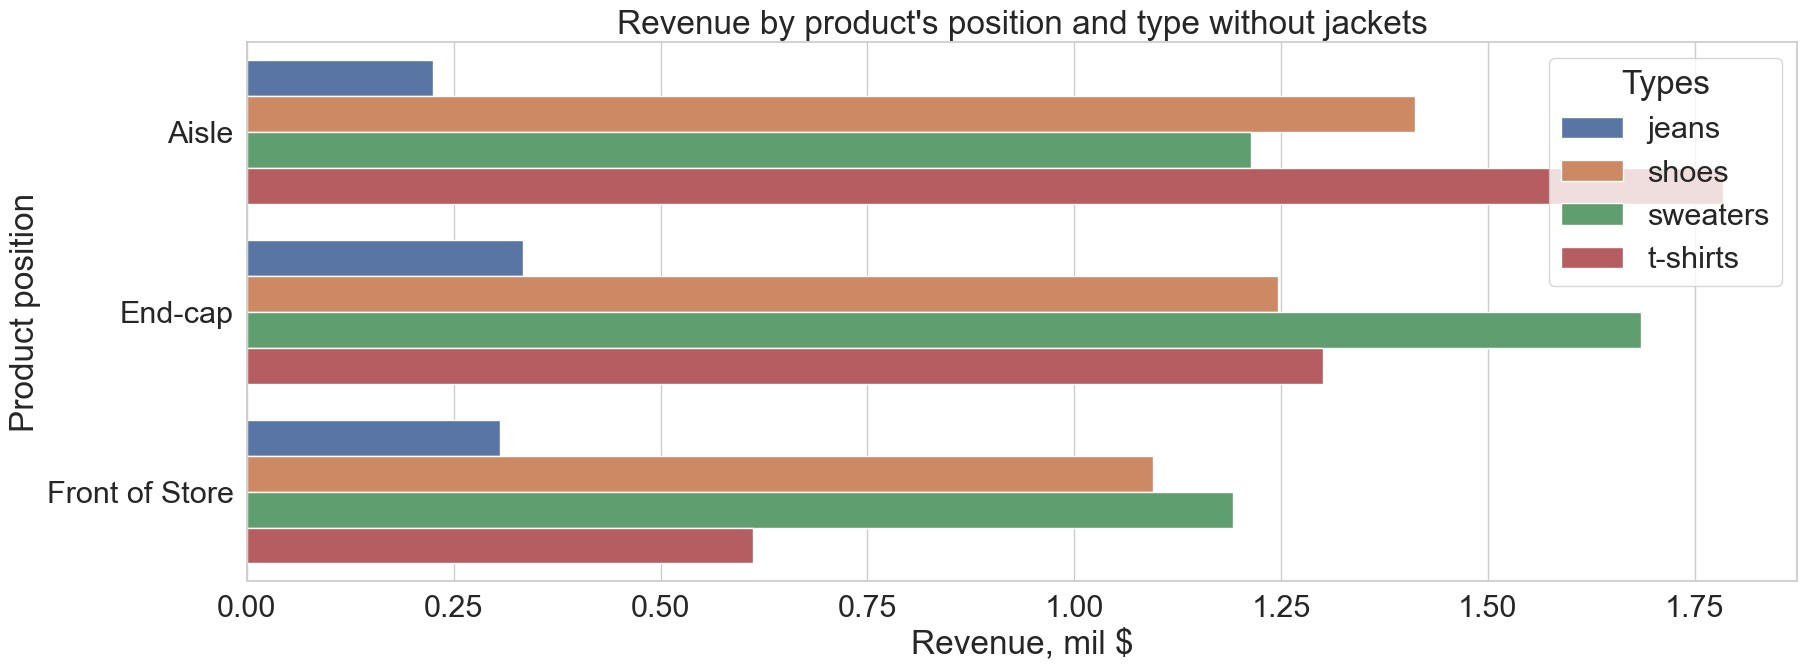

In [47]:
rev_by_prod_pos_w_terms_df_wo_jack = rev_by_prod_pos_w_terms_df \
                                    .drop(rev_by_prod_pos_w_terms_df \
                                        .loc[rev_by_prod_pos_w_terms_df.terms == 'jackets'] \
                                        .index)

ax3_3 = sns.barplot(y   = rev_by_prod_pos_w_terms_df_wo_jack.product_position,
                    x   = rev_by_prod_pos_w_terms_df_wo_jack.revenue_by_item / 1000000,
                    hue = rev_by_prod_pos_w_terms_df_wo_jack.terms.rename('Types'))
ax3_3.set(xlabel='Revenue, mil $', ylabel='Product position')
ax3_3.set_title('''Revenue by product's position and type without jackets''')

# мы знаем, что shoes, sweaters, t-shirts приносят примерно одинаковую выручку, поэтому интересно как 
# местоположение в зале магазина влияет на выручку с каждой из этих категорий.
# Судя по полученным ниже зависимостям, в Aisle выгоднее всего выставлять t-shirts, 
# в End-cap - sweaters, а Front of store почти одинаково выгоден и для shoes, и sweaters.

Text(0.5, 1.0, "Sales volume by product's position boxplot distribution")

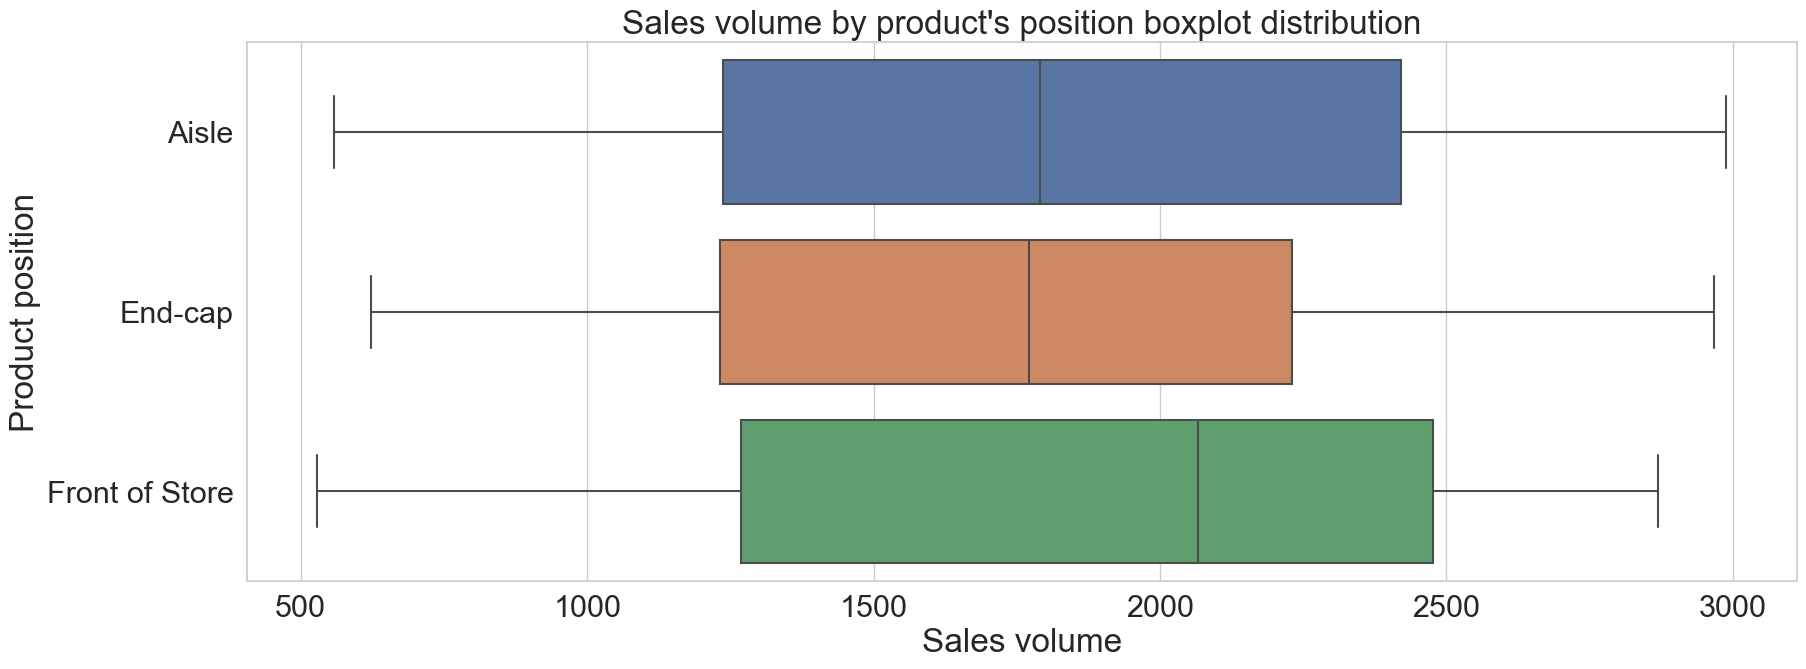

In [48]:
ax4_1 = sns.boxplot(x = sales.sales_volume, y = sales.product_position)

ax4_1.set(xlabel='Sales volume', ylabel='Product position')
ax4_1.set_title('''Sales volume by product's position boxplot distribution''')

# Оценим объемы продаж товаров в штуках в зависимости от местоположения в магазине

Text(0.5, 1.0, "Sales volume by product's position and type boxplot distribution")

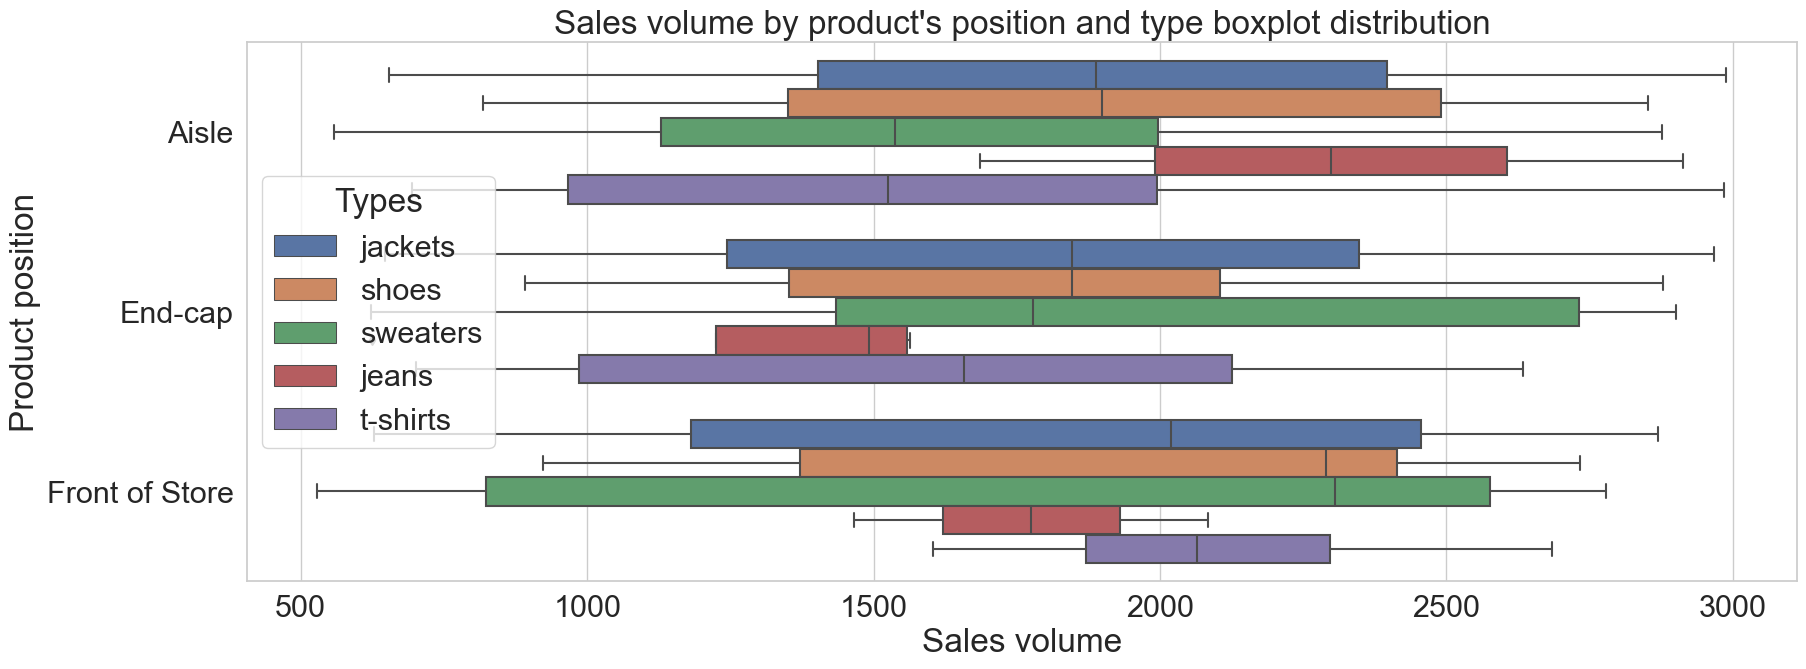

In [49]:
ax4_2=sns.boxplot(x = sales.sales_volume, 
            y = sales.product_position,
            hue = sales.terms.rename('Types'))

ax4_2.set(xlabel='Sales volume', ylabel='Product position')
ax4_2.set_title('''Sales volume by product's position and type boxplot distribution''')

# Строим боксплот по количеству проданного товара в зависимости от его типа и местонахождения в магазине

In [50]:
# Попробуем изучить распределение количества проданных товаров, sales_volume

In [51]:
sales.sales_volume.describe()

# Для sales_volume среднеквадратичное отклонение и среднее: std ~ 700, mean ~ 1822

count     250.000000
mean     1822.224000
std       700.136055
min       529.000000
25%      1239.000000
50%      1836.500000
75%      2402.250000
max      2989.000000
Name: sales_volume, dtype: float64

Text(0.5, 0.98, 'Sales volume distribution')

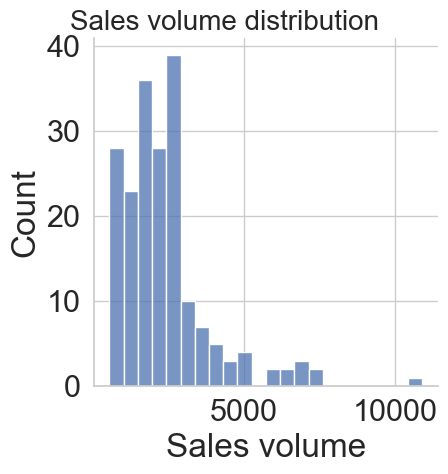

In [52]:
ax5_1 = sns.displot(sales.groupby('name', as_index=False).sales_volume.sum().sales_volume.rename('Sales volume'))
ax5_1.fig.suptitle("Sales volume distribution",
                  fontsize=20, 
                  fontdict={"weight": "bold"})

# Распределение количества проданных товаров, сгруппированных по названию

In [53]:
sales.groupby('name', as_index=False).sales_volume.sum().query('sales_volume > 10000')

# Смотрим, что за товар у нас является выбросом на графике выше

# Это абсолютный лидер по количеству продаж, он также входит в топ-10 товаров по принесенной выручке

,name,sales_volume
118,PLAID OVERSHIRT,10910


Text(0.5, 0.98, "Log'ed sales volume distribution")

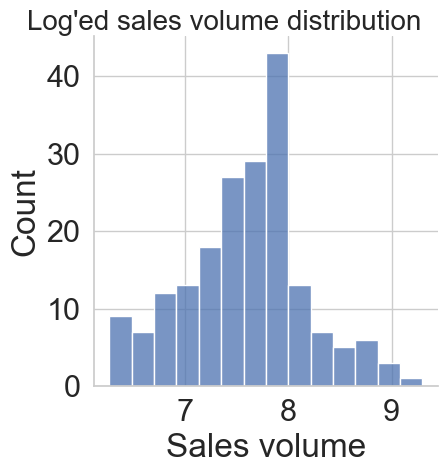

In [54]:
ax5_2 = sns.displot(np.log(sales.groupby('name', as_index=False).sales_volume.sum().sales_volume.rename('Sales volume')))
ax5_2.fig.suptitle("Log'ed sales volume distribution",
                  fontsize=20, 
                  fontdict={"weight": "bold"})

# Логарифмируем количество проданных товаров,
# чтобы преобразовать скошенное распределение на графике сверху в похожее на нормальное

In [55]:
stats.shapiro(np.log(sales.groupby('name', as_index=False).sales_volume.sum().sales_volume))

# Тест Шапиро-Уилка на нормальность распределения. Полученное значение p-value говорит о том, что стоит отклонить 
# гипотезу о нормальности распределения.

ShapiroResult(statistic=0.9854638513849274, pvalue=0.043943617505595944)

In [56]:
pg.normality(np.log(sales.groupby('name', as_index=False).sales_volume.sum().sales_volume))

# Еще один тест на нормальность по Шапиро, реализованный в другом стат пакете, дал такой же результат, что и выше

,W,pval,normal
sales_volume,0.985464,0.043944,False


<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

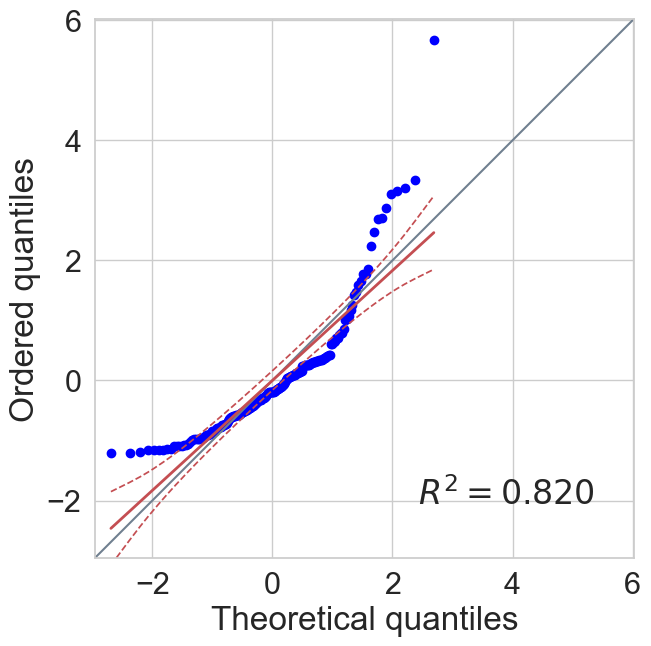

In [57]:
pg.qqplot((sales.groupby('name', as_index=False).sales_volume.sum().sales_volume))

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

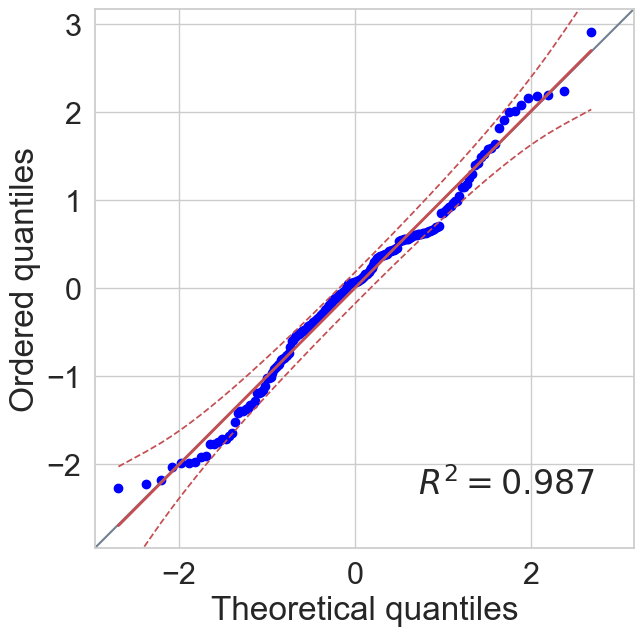

In [58]:
# Попробуем построить qqplot

pg.qqplot(np.log(sales.groupby('name', as_index=False).sales_volume.sum().sales_volume))

In [59]:
# Можно сказать, что распределение стремится к нормальному

In [60]:
# В настоящих условиях возможно применить t-тест к распределению логарифма количества проданных товаров

In [61]:
sales_vol_jackets = np.log(sales[sales.terms == "jackets"].sales_volume)
sales_vol_jeans = np.log(sales[sales.terms == "jeans"].sales_volume)
sales_vol_sweaters = np.log(sales[sales.terms == "sweaters"].sales_volume)
sales_vol_shoes = np.log(sales[sales.terms == "shoes"].sales_volume)
sales_vol_t_shirts = np.log(sales[sales.terms == "t-shirts"].sales_volume)

# Создаем переменные по типам товаров с логарифмированными столбцами количества проданных штук (sales_volume)

In [62]:
sales_vol_types_list = [sales_vol_jackets, sales_vol_jeans, sales_vol_sweaters, sales_vol_shoes, sales_vol_t_shirts]

for prod_type in sales_vol_types_list:
    print(prod_type.shape[0])

# В выборке джинс (jeans) наблюдений всего 8, поэтому с ними будет тяжело
# В остальных выборках наблюдений >30, что является хорошими вводными для использования t-теста

138
8
41
31
32


In [63]:
stats.ttest_ind(sales_vol_jackets, sales_vol_shoes)

# Проверяем гипотезу о том, что логарифмированные средние значения проданных jackets и shoes статистически отличаются
# Т-тест показывает, что мы не можем отвергнуть эту гипотезу

TtestResult(statistic=-0.3220215177138153, pvalue=0.7478391345494901, df=167.0)

In [64]:
stats.mannwhitneyu(sales_vol_jackets, sales_vol_shoes)

# Снова проверяем гипотезу,  что логарифмированные средние значения проданных jackets и shoes статистически отличаются,
# но теперь с помощью теста Манна-Уитни, чтобы не обращать внимание на результат тестов Шапиро
# Тест Манна-Уитни показывает, 
# что мы не можем отвергнуть гипотезу о равенстве логарифмированных средних ГС для jackets и shoes

MannwhitneyuResult(statistic=2123.5, pvalue=0.951414092157202)

In [65]:
stats.f_oneway(sales_vol_jackets, sales_vol_jeans, sales_vol_sweaters, sales_vol_shoes, sales_vol_t_shirts)

# Применим дисперсионный однофакторный анализ для логарифмированного количества проданных товаров по их типу,
# результат которого не позволяет нам # отменить нулевую гипотезу о том,
# что средние количества проданных товаров по типу товара не отличаются

F_onewayResult(statistic=0.5701638899079164, pvalue=0.6845319952512904)

In [66]:
pg.homoscedasticity(data=sales, dv='sales_volume', group='terms', center='median')

# Проверка на гомоскедатичность или же на примерное равенство дисперсий количества продаж по типам товаров
# Тест показал, что с дисперсией все в порядке

,W,pval,equal_var
levene,1.379705,0.241514,True


In [67]:
pg.anova(data=sales, dv='sales_volume', between='terms')

# Снова применили дисперсионный однофакторный анализ, но уже для количества проданных товаров по их типу без логарифма, 
# с другой библиотекой. Результат похож

,Source,ddof1,ddof2,F,p-unc,np2
0,terms,4,245,0.540243,0.706312,0.008743


[Text(0.5, 0, 'Types'),
 Text(0, 0.5, 'Sales volume'),
 Text(0.5, 1.0, 'Sales volume means dependency on type of product')]

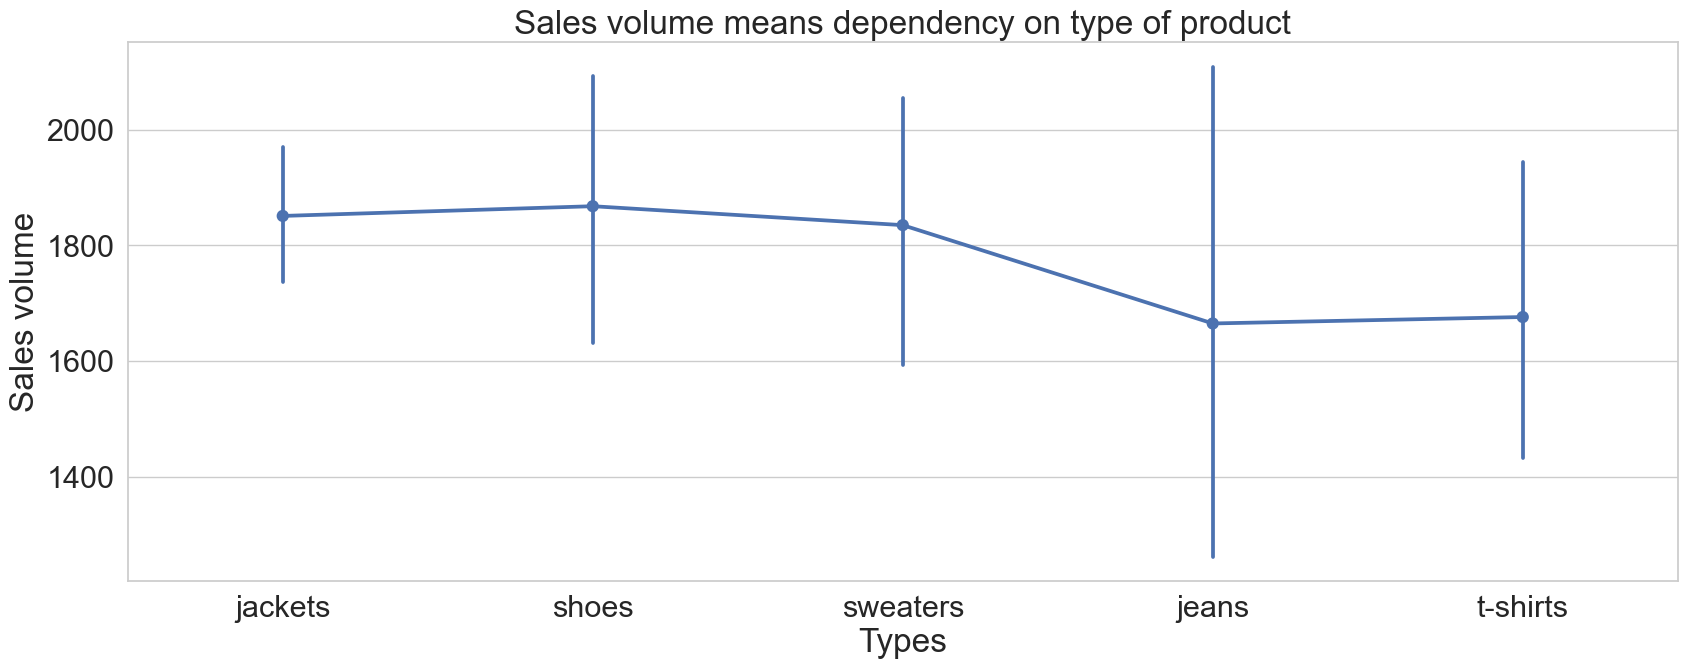

In [68]:
ax6 = sns.pointplot(x='terms', y='sales_volume', data=sales, errorbar = 'ci')
ax6.set(xlabel = 'Types',
        ylabel = 'Sales volume',
        title = 'Sales volume means dependency on type of product')

# Строим график среднего количества продаж по типу товара с 95% доверительными интервалами
# По нему действительно можно сказать, что количество продаж по типу товара не сильно отличается

In [69]:
pg.anova(data=sales, dv='sales_volume', between=['terms', 'product_position'])

# Проведем многофакторный дисперсионный анализ количества проданного товара, 
# где в качестве факторов укажем тип продукта (terms) и позицию продукта в магазина (product_position)

# По его результатам, в частности, по показателю np2, можно сказать, что большая часть дисперсии покрывается
# эффектом взаимосвязи между типом продукта и его позицией в магазине. 
# При этом p-value не позволяет отклонить нулевую гипотезу о равенстве средних для каждого из факторов
# Таким образом, нет смысла проводить множественные сравнения ни для одного из факторов

# Получается, люди одинаково покупают все типы продуктов

,Source,SS,DF,MS,F,p-unc,np2
0,terms,9.514279e+05,4.0,237856.987418,0.474029,0.754784,0.008004
1,product_position,2.728043e+05,2.0,136402.172952,0.271838,0.762217,0.002308
2,terms * product_position,2.799779e+06,8.0,349972.331154,0.697465,0.693658,0.023193
3,Residual,1.179177e+08,235.0,501777.364574,NaN,NaN,NaN


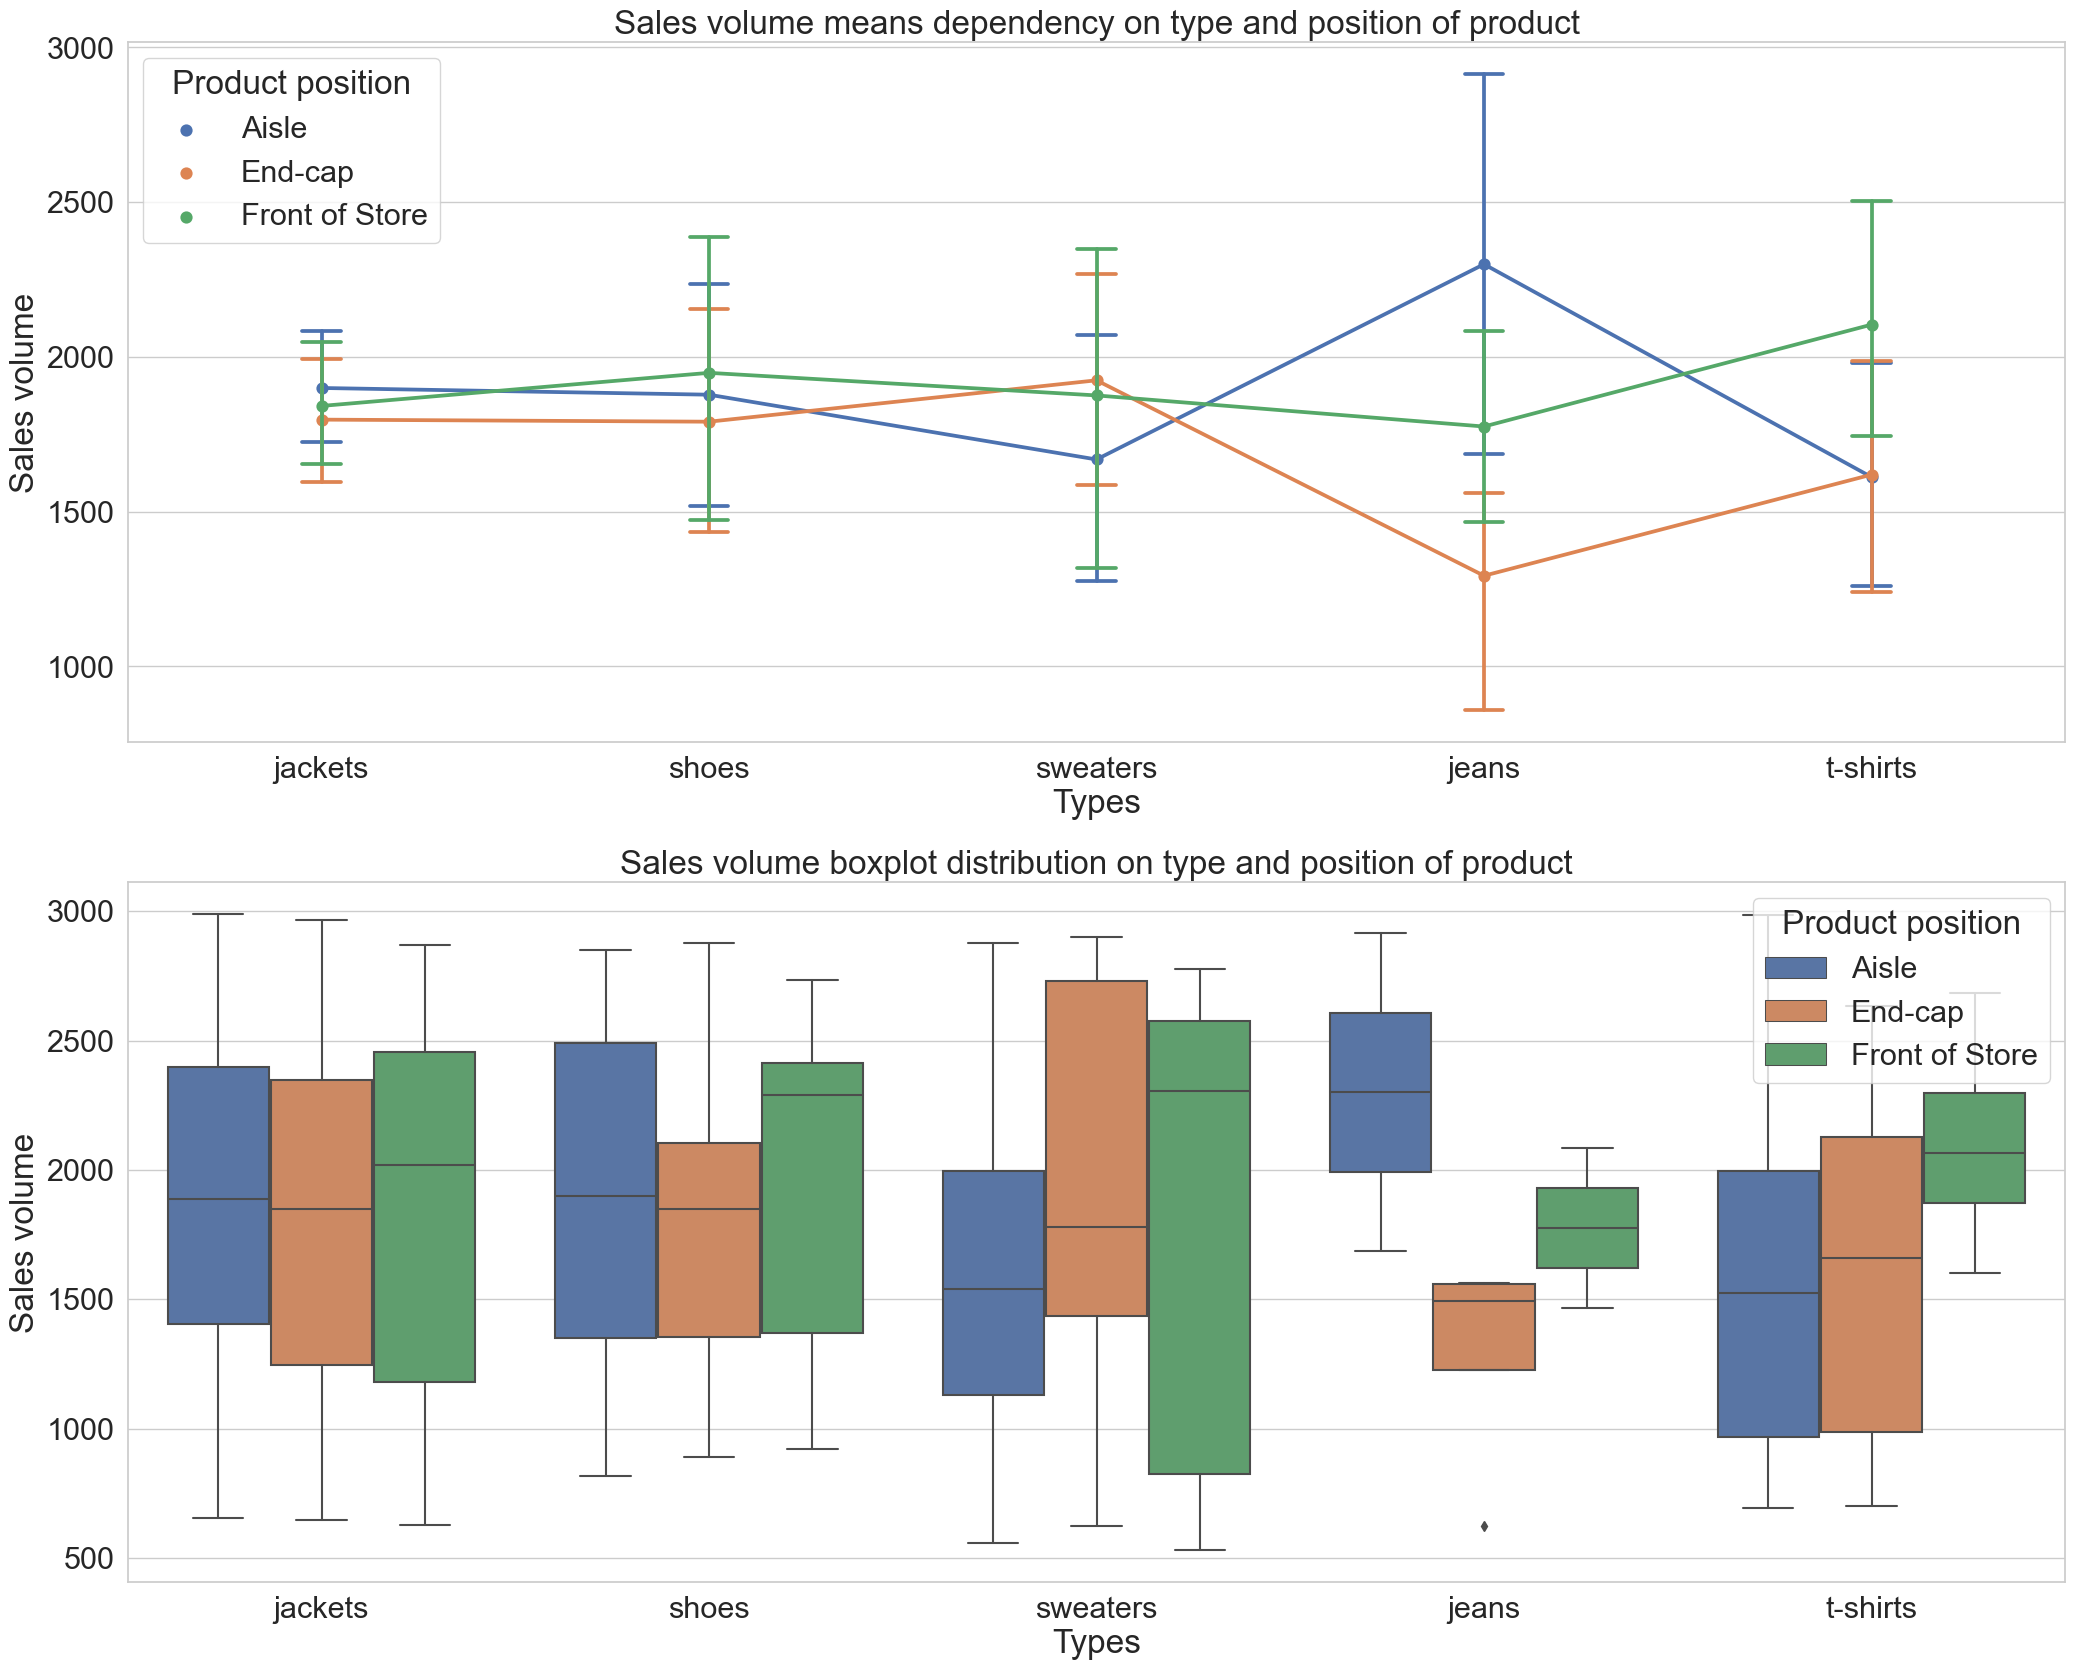

In [70]:
fig, axes = plt.pyplot.subplots(nrows=2,ncols=1, figsize=(25,20))

sns.pointplot(x='terms', y='sales_volume', hue='product_position', data=sales, capsize=0.1, ax = axes[0])
axes[0].set(xlabel = 'Types',
        ylabel = 'Sales volume',
        title = 'Sales volume means dependency on type and position of product')
axes[0].legend(title='Product position')

sns.boxplot(x='terms', y='sales_volume', hue='product_position', data=sales, ax = axes[1])
axes[1].set(xlabel = 'Types',
        ylabel = 'Sales volume',
        title = 'Sales volume boxplot distribution on type and position of product')
axes[1].legend(title='Product position')

# Построили график зависимости средних количества продаж в зависимости от типа товара и его позиции в магазине,
# а также боксплот распределение этой величины, т.к. первый график оказался не очень удобным для анализа

# Из боксплота видно, что только категория джинс в зависимости от позиции магазина может иметь разные средние количества продаж
# для каждой позиции в магазине. Проверим так ли это в следующем блоке

In [71]:
pg.pairwise_tukey(data=sales.query('terms == "jeans"'), dv="sales_volume", between="product_position")

# По критерию Тьюки мы не можем отвергнуть гипотезу о том, что средние количества продаж джинс 
# с разных позиций в магазине статистически не различаются

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Aisle,End-cap,2299.50,1292.75,1006.75,482.890865,2.084840,0.187713,1.379428
1,Aisle,Front of Store,2299.50,1775.00,524.50,557.594342,0.940648,0.640979,0.435748
2,End-cap,Front of Store,1292.75,1775.00,-482.25,482.890865,-0.998673,0.608994,-0.863033


In [72]:
# Исследуем данные на вопрос наличия взаимосвязи между параметрами и их силы

In [73]:
sales[['sales_volume', 'price', 'revenue_by_item']].corr()

# Строим корреляционную матрицу датафрейма sales
# Можно предположить, что взаимосвязи между ценой и количеством проданных товаров нет,
# в то время как есть положительная взаимосвязь между количеством проданного товара и выручкой с нее,
# а также между ценой и выручкой товра

# Проверим так ли это

,sales_volume,price,revenue_by_item
sales_volume,1.000000,-0.082724,0.514110
price,-0.082724,1.000000,0.733487
revenue_by_item,0.514110,0.733487,1.000000


[Text(0.5, 0, 'Price'),
 Text(0, 0.5, 'Sales volume'),
 Text(0.5, 1.0, 'Sales volume/Price scatter plot')]

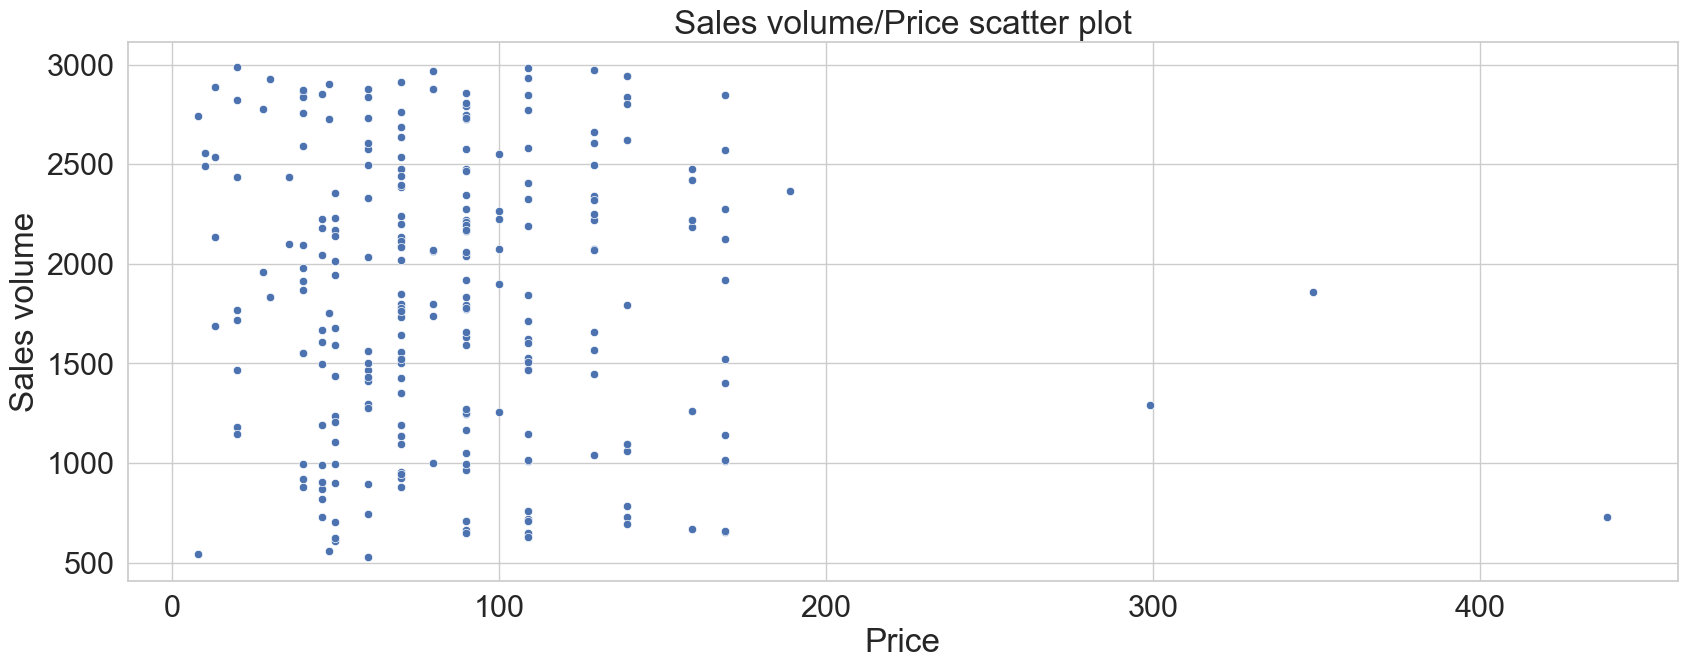

In [74]:
ax7_1 = sns.scatterplot(data=sales, x = 'price', y='sales_volume')
ax7_1.set(xlabel = 'Price', ylabel = 'Sales volume', title = 'Sales volume/Price scatter plot')

# Построим график рассеяния данных по параметрам цены и количества проданных товаров
# На первый взгляд данные распределены равномерно, за исключением пары выбросов

In [75]:
stats.pearsonr(sales.price, sales.sales_volume)

# Проверим гипотезу об отсутствии связи между параметрами цены и количества проданного товара
# Полученное p-value не позволяет и близко отвергнуть данную гипотезу

PearsonRResult(statistic=-0.082724078977165, pvalue=0.19234848668891125)

In [76]:
stats.spearmanr(sales.price, sales.sales_volume)

# Поскольку в данных выше на диаграмме рассеяния есть некоторое количество выбросов 
# имеет смысл рассчитать непараметрический коэффициент корреляции Спирмена,
# который также указывает на отсутствие взаимосвязи между ценой и количеством проданного товара

SignificanceResult(statistic=-0.03474993945293075, pvalue=0.5844773769758158)

[Text(0.5, 0, 'Price'),
 Text(0, 0.5, 'Revenue'),
 Text(0.5, 1.0, 'Revenue/Price scatter plot')]

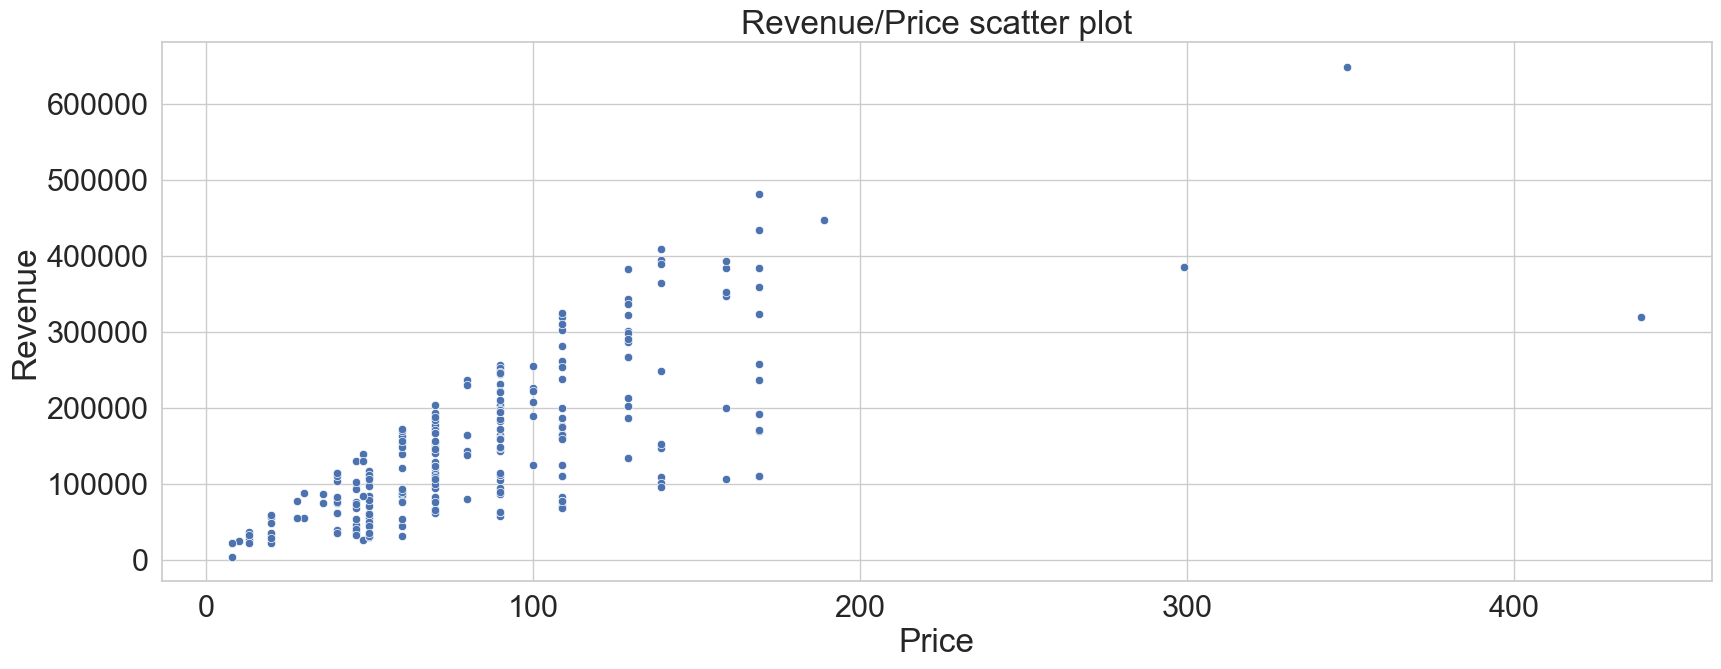

In [77]:
ax7_2 = sns.scatterplot(data=sales, x = 'price', y='revenue_by_item')
ax7_2.set(xlabel = 'Price', ylabel = 'Revenue', title = 'Revenue/Price scatter plot')

# Построим теперь диаграмму рассеяния параметров цены и выручки с товаров
# Наблюдается несколько выбросов
# Предположительно параметры имеют положительную взаимосвязь

In [78]:
stats.spearmanr(sales.price, sales.revenue_by_item)

# Коэффициент корреляции Спирмена позволяет отклонить гипотезу о том, что корреляции между ценой и выручкой с товара нет,
# что подтверждает выводы из корреляционной матрицы. 
# Более того, взаимосвязь значительна и положительна: cr = 0.75

SignificanceResult(statistic=0.7554088604666095, pvalue=1.969489600044837e-47)

[Text(0.5, 0, 'Price'),
 Text(0, 0.5, 'Revenue'),
 Text(0.5, 1.0, 'Revenue/Price regression line')]

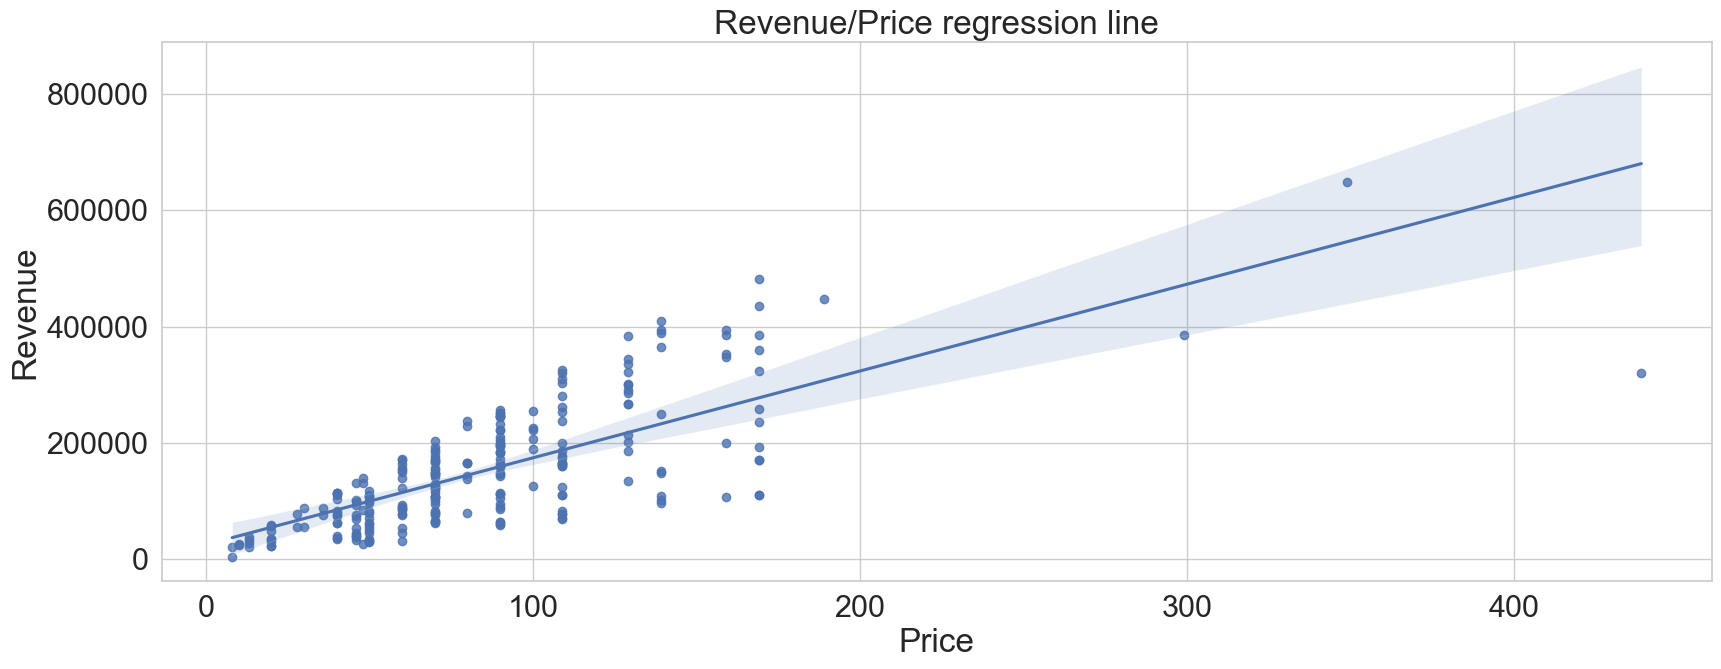

In [79]:
ax7_2_2= sns.regplot(data=sales, x = 'price', y='revenue_by_item')
ax7_2_2.set(xlabel = 'Price', ylabel = 'Revenue', title = 'Revenue/Price regression line')

# Построим регрессионную прямую для зависимости выручки от цены товара

[Text(0.5, 0, 'Sales volume'),
 Text(0, 0.5, 'Revenue'),
 Text(0.5, 1.0, 'Revenue/Sales volume scatter plot')]

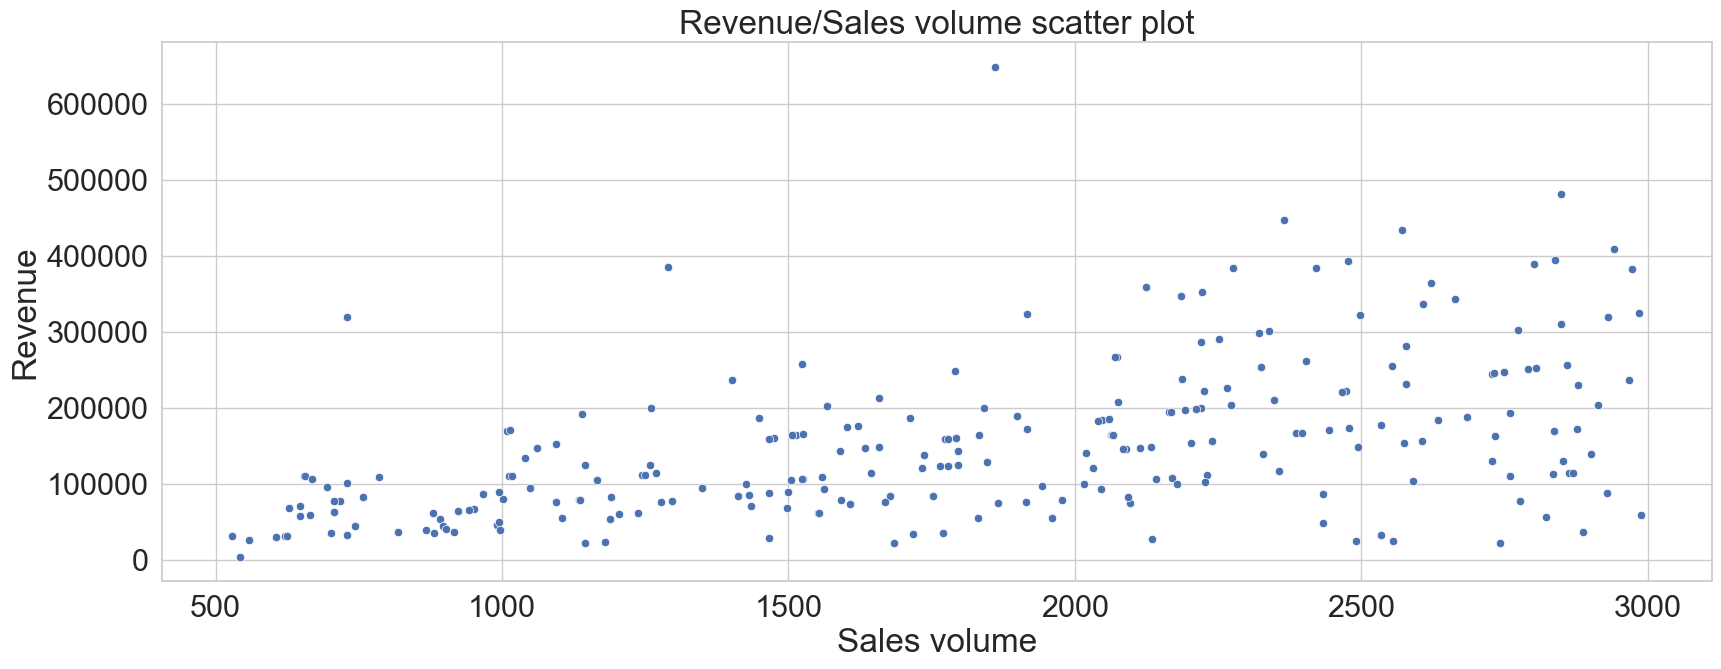

In [80]:
ax7_3 = sns.scatterplot(data=sales, x = 'sales_volume', y='revenue_by_item')
ax7_3.set(xlabel = 'Sales volume', ylabel = 'Revenue', title = 'Revenue/Sales volume scatter plot')

# Построим теперь диаграмму рассеяния параметров выручки и количества проданных товаров
# Наблюдается несколько выбросов
# Предположительно параметры имеют положительную взаимосвязь

In [81]:
stats.spearmanr(sales.sales_volume, sales.revenue_by_item)

# Коэффициент корреляции Спирмена позволяет отклонить гипотезу о том, 
# что корреляции между выручкой и количеством проданного товара нет,
# что подтверждает выводы из корреляционной матрицы. 
# Сила взаимосвязи при этом составила положительную величину cr = 0.55

SignificanceResult(statistic=0.5570795754210224, pvalue=8.820802884574197e-22)

[Text(0.5, 0, 'Sales volume'),
 Text(0, 0.5, 'Revenue'),
 Text(0.5, 1.0, 'Revenue/Sales volume regression line')]

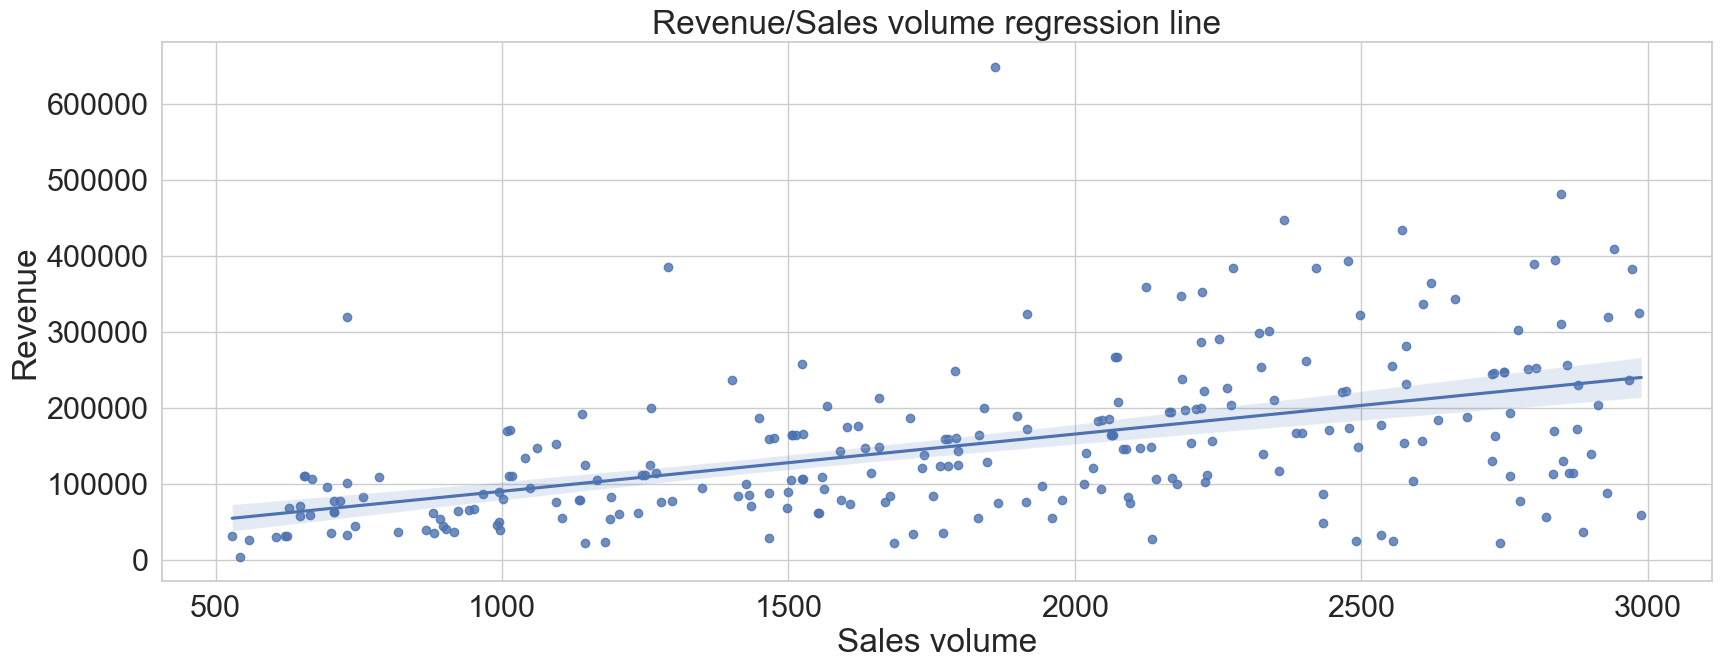

In [82]:
ax7_3_2= sns.regplot(data=sales, x = 'sales_volume', y='revenue_by_item')
ax7_3_2.set(xlabel = 'Sales volume', ylabel = 'Revenue', title = 'Revenue/Sales volume regression line')

# Построим регрессионную прямую для зависимости выручки от количества проданного товара

In [ ]:
# Построим теперь регрессионную модель для предсказания выручки с товара

In [120]:
sales_columns_to_lr = ['product_position', 'promotion', 'seasonal', 'sales_volume', 'price', 'terms', 'section', 'revenue_by_item']

# Отберем предикторы и зависимую переменную (ЗП) - revenue_by_item

In [163]:
sales_with_dummies = pd.get_dummies(data=sales[sales_columns_to_lr], drop_first = True)

# Создадим датафрейм с предикторами и ЗП, разбив категориальные переменные на столбцы с 0 и 1

In [165]:
X = sales_with_dummies.drop(['revenue_by_item'], axis='columns')
Y = sales_with_dummies.revenue_by_item
X = sm.add_constant(X)

# Создадим массив с предикторами и массив с ЗП

In [166]:
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

# Создадим регрессионную модель с отобранными предикторами и ЗП, зафитим ее и посмотрим на результаты

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        revenue_by_item   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     147.8
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           1.12e-99
Time:                        00:17:36   Log-Likelihood:                -2981.6
No. Observations:                 250   AIC:                             5987.
Df Residuals:                     238   BIC:                             6029.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                           -1.358e+05   1.05e+04    -12.921      0.000   -1.57e+05   -1.15e+05
sales_volume                       84.9686      3.436     24.728      0.000      78.200      91.738
price                            1573.0551     53.014     29.672      0.000    1468.618    1677.492
product_position_End-cap         1426.6810   5661.438      0.252      0.801   -9726.247    1.26e+04
product_position_Front of Store -4261.4891   5975.873     -0.713      0.476    -1.6e+04    7510.870
promotion_Yes                    2143.8872   4817.837      0.445      0.657   -7347.163    1.16e+04
seasonal_Yes                     1327.0783   4898.419      0.271      0.787   -8322.718     1.1e+04
terms_jeans                       872.0758   1.39e+04      0.063      0.950   -2.65e+04    2.82e+04
terms_shoes                     -4777.8290   7794.002     -0.613      0.540   -2.01e+04    1.06e+04
terms_sweaters                  -1.313e+04   1.49e+04     -0.878      0.381   -4.26e+04    1.63e+04
terms_t-shirts                   1292.2893   7731.998      0.167      0.867   -1.39e+04    1.65e+04
section_WOMAN                    6326.5778   1.59e+04      0.398      0.691    -2.5e+04    3.76e+04
==============================================================================
Omnibus:                      155.008   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3003.972
Skew:                          -2.038   Prob(JB):                         0.00
Kurtosis:                      19.486   Cond. No.                     1.74e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.74e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [167]:
# Полученная модель демонстрирует с помощью параметра Adj. R-squared относительно высокое покрытие дисперсии, 0.866
# В то же время статистически значимыми предикторами явились лишь количество проданного товара и его цена
# Они говорят, что при увеличении проданного товара на единицу выручка товара в среднем растет на 85$. 
# При увеличении же цены на 1 $ выручка вырастает сразу на 1573$

In [168]:
# Посмотрим, какую именно часть дисперсии в нашей регрессионной модели занимает цена и количество проданного товара

In [169]:
X2 = X.drop(['sales_volume', 'price'], axis='columns')
X2 = sm.add_constant(X2)

# Убираем из массива, подающегося на вход модели линейной регрессии, предикторы цена и количество проданного товара

In [170]:
model2 = sm.OLS(Y, X2)
results2 = model2.fit()
results2.summary()

# Строим модель без убранных предикторов

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        revenue_by_item   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     4.704
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           9.18e-06
Time:                        00:17:37   Log-Likelihood:                -3218.5
No. Observations:                 250   AIC:                             6457.
Df Residuals:                     240   BIC:                             6492.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            1.853e+05   1.44e+04     12.842      0.000    1.57e+05    2.14e+05
product_position_End-cap        -1.541e+04   1.45e+04     -1.063      0.289    -4.4e+04    1.31e+04
product_position_Front of Store -4202.7399   1.53e+04     -0.274      0.784   -3.44e+04     2.6e+04
promotion_Yes                    1.766e+04   1.23e+04      1.436      0.152   -6569.731    4.19e+04
seasonal_Yes                    -3309.1932   1.26e+04     -0.263      0.793   -2.81e+04    2.15e+04
terms_jeans                      -7.39e+04   3.52e+04     -2.100      0.037   -1.43e+05   -4575.673
terms_shoes                     -6.609e+04   1.93e+04     -3.429      0.001   -1.04e+05   -2.81e+04
terms_sweaters                  -5.873e+04   3.83e+04     -1.535      0.126   -1.34e+05    1.66e+04
terms_t-shirts                  -7.043e+04   1.91e+04     -3.682      0.000   -1.08e+05   -3.27e+04
section_WOMAN                   -2.969e+04   4.06e+04     -0.731      0.465    -1.1e+05    5.03e+04
==============================================================================
Omnibus:                       61.298   Durbin-Watson:                   1.701
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.013
Skew:                           1.202   Prob(JB):                     1.59e-28
Kurtosis:                       5.552   Cond. No.                         12.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [174]:
# Показатель Adj. R-squared оказался равен 0.118, т.е. в сравнении с предыдущей моделью, где этот показатель был 0.866,
# всего два предиктора покрывают примерно 75% всей дисперсии нашей выборки. При этом они же являются единственными стат.
# значимыми.